# <span style="color:red; font-weight:bold;">Bhasin Systems Biomedicine Lab</span> <span style="color:black; font-weight:bold;"> |  Seurat_v5 Implementation</span>

> ***This notebook presents the utilization of the Seurat_v5 package to analyze single-cell RNA sequencing data from a sample dataset of Human Glioblastoma Multiforme (GBM) sourced from the 10X Genomics scRNA-seq database.***

## <span style="color:blue; font-weight:bold;">1. scRNA-seq Dataset</span>


**Data: Brain_Tumor_3p - 2k Sorted Cells from Human Glioblastoma Multiforme (GBM), 3`v3.1** 

**Data Type: Feature-barcode UMI count matrix generated using cellranger pipeline (10X Genomics)**

**Data Format: HDF5/H5**

**Estimated Number of Cells: 1615**

**Sequencing Depth: 72,259 mean reads per cell**

**Data Source: 10X Genomics Single Cell Gene Expression Database**

**Dataset Link: https://www.10xgenomics.com/datasets/2-k-sorted-cells-from-human-glioblastoma-multiforme-3-v-3-1-3-1-standard-6-0-0**

## <span style="color:blue; font-weight:bold;">2. Install Packages</span>

In [ ]:
install.packages("Seurat") #Seurat_v5 
install.packages("hdf5r") #package to read HDF5 files in R

## <span style="color:blue; font-weight:bold;">3. Load Libraries</span>

In [ ]:
library(Seurat)
library(hdf5r)
library(dplyr)
library(patchwork)
library(ggplot2)
library(ggrepel)
library(purrr)

## <span style="color:blue; font-weight:bold;">4. Load GBM Dataset</span>

In [ ]:
#Load GBM dataset
gbm.sparse.data <- Read10X_h5(filename = 'E:\\Masters\\GATech\\Fall_2024\\GRA\\Manoj_Bhasin\\Task\\GBM_dataset\\Brain_Tumor_3p_raw_feature_bc_matrix.h5', use.names = TRUE, unique.features = TRUE)
#Check dataset structure
str(gbm.sparse.data)
#head - gbm.sparse.data
head(gbm.sparse.data)

## <span style="color:blue; font-weight:bold;">5. Create and initialise Seurat Object with raw (non-normalized) data</span>

In [ ]:
#Seurat object creation with GBM sparse.data and cutoffs set for min.cells (Filter features that are detected in a minimum number of cells) and min.features (Filter cells based on the number of features detected)
gbm.seurat.obj <- CreateSeuratObject(counts = gbm.sparse.data, project = "GBM", min.cells = 3, min.features = 200)
#Structure of seurat object - gbm.seurat.obj
str(gbm.seurat.obj)
#head - gbm.seurat.obj
head(gbm.seurat.obj)

## <span style="color:blue; font-weight:bold;">6. Data Pre-processing</span>


> **Data pre-processing stage represents the filtration and selection of cells based on the following steps executed below:**

### <span style="color:OrangeRed; font-weight:bold;">6.1 Quality Control (QC)</span>

> **QC step includes the filteration of low-quality cells based on the following metrics: (Adapted based on the standard pipelines)**

1. Filerting by number of unique features detected in each cell:
    >> High feature counts = Doublets/multiplets \
    >> Low feature counts = Ambient RNA (Not real cells)/empty droplets/low-quality cells

2. Filtering by UMI counts (total number of molecules) detected in each cell:
    >> High UMI counts = Doublets/multiplets \
    >> Low UMI counts = Ambient RNA (Not real cells)/empty droplets/low-quality cells

3. Filtering by mitochondrial (MT) reads percentage detected in each cell:
    >> High mt reads = Unhealthy/low-quality/dying cells (mitochondrial contamination)

4. Filtering by ribosomal (RB) reads percentage detected in each cell:
    >> High levels of rRNA reads (rRNA contamination) skew scRNA-seq downstream analysis.

> **Since the dataset I have considered here is of a tumor sample, the QC metrics cutoffs for cancer cells differs from healthy cells, which I explain it in detail below, respectively;**

#### <span style="color:maroon; font-weight:bold;">6.1.1 % MT reads (mtRNA) and % RB reads (rRNA)</span>

In [5]:
#View the meta.data slot of the seurat object
head(gbm.seurat.obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCACATGTGTCA-1,GBM,15621,2821
AAACGAAAGAGAACCC-1,GBM,19897,3501
AAACGAATCCCTTCCC-1,GBM,881,277
AAACGCTAGATTAGAC-1,GBM,2856,1365
AAACGCTGTACGCTAT-1,GBM,31357,4350
AAACGCTGTTATAGCC-1,GBM,748,261


> As observed in the above cell, the current meta.data slot of the seurat object (gbm.seurat.obj) contains only the counts for number of UMI detected and features, assigned to respective barcodes (cells). Hence it is required to include the % MT reads and % RB reads detected per cell (barcode) in the meta.data slot of our seurat object (gbm.seurat.obj) to further the QC process.

In [6]:
#Step to include % MT reads in the meta.data slot of our seurat object (gbm.seurat.obj) using "PercentageFeatureSet" function
gbm.seurat.obj[["percent.mt"]] <- PercentageFeatureSet(gbm.seurat.obj, pattern = "^MT-")
#Step to include % RB reads in the meta.data slot of our seurat object (gbm.seurat.obj) using "PercentageFeatureSet" function
gbm.seurat.obj[["percent.rb"]] <- PercentageFeatureSet(gbm.seurat.obj, pattern = "^RP[SL]")
#View the modified meta.data slot of the seurat object - check for the presence of % MT reads column
head(gbm.seurat.obj@meta.data)


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACCCACATGTGTCA-1,GBM,15621,2821,10.876384,16.06811
AAACGAAAGAGAACCC-1,GBM,19897,3501,5.734533,24.25491
AAACGAATCCCTTCCC-1,GBM,881,277,58.569807,11.01022
AAACGCTAGATTAGAC-1,GBM,2856,1365,3.781513,19.43277
AAACGCTGTACGCTAT-1,GBM,31357,4350,6.017795,17.83653
AAACGCTGTTATAGCC-1,GBM,748,261,26.604278,12.70053


#### <span style="color:maroon; font-weight:bold;">6.1.2 Pre-filtering visualisation of the QC metrics</span>

> Prior to filtering process, it is preferred to visualise the distribution of the required QC metrics for better understanding of the dataset and to decide the cutoff values.

##### <span style="color:black; font-weight:bold;">6.1.2.1 Violin Plot</span>

> Violin plot depicts the distribution of the respective QC metrics with respect to individual cell.

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


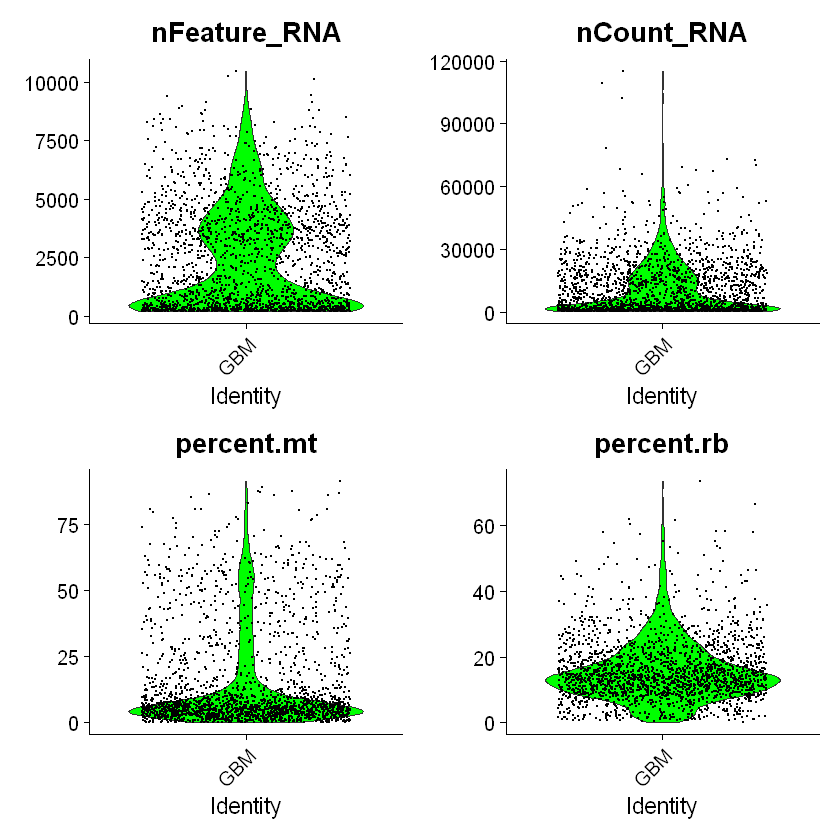

In [7]:
#Visualize QC metrics as a violin plot using "VlnPlot" fucntion of Seurat package
VlnPlot(gbm.seurat.obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 2, cols = "green")

##### <span style="color:black; font-weight:bold;">6.1.2.2 Scatter plot | feature - feature relationship</span>

> Scatter plot depicts the relationship between the metrics by Pearson correlation with respect to individual cell.

> **1. nFeature_RNA vs nCount_RNA**

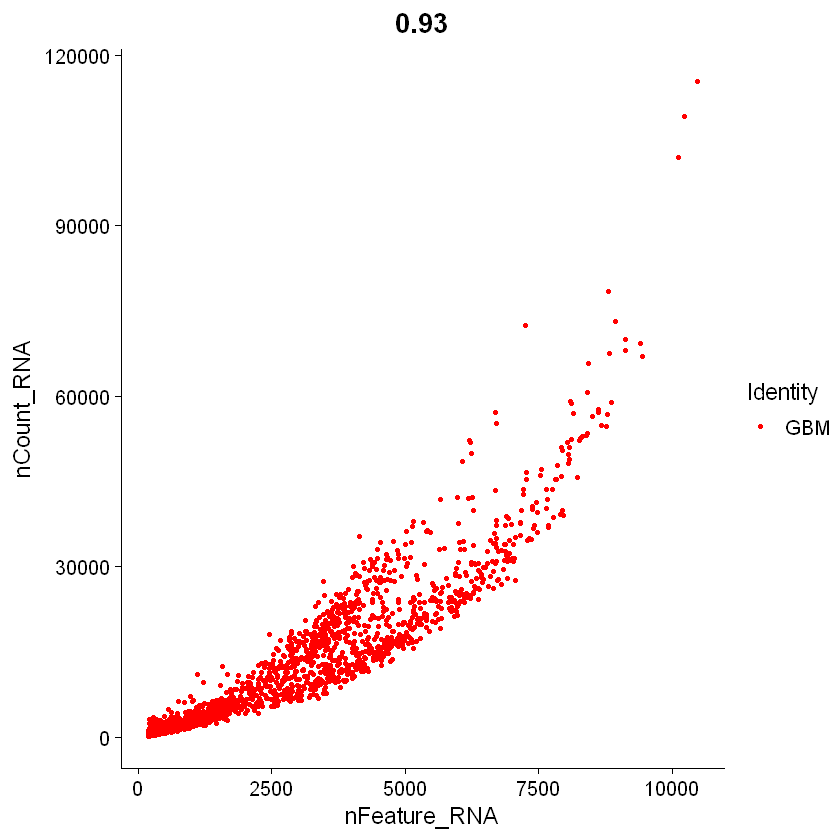

In [8]:
scatt1 <- FeatureScatter(gbm.seurat.obj, feature1 = "nFeature_RNA", feature2 = "nCount_RNA", cols = "red")
scatt1

> **2. nFeature_RNA vs percent.mt**

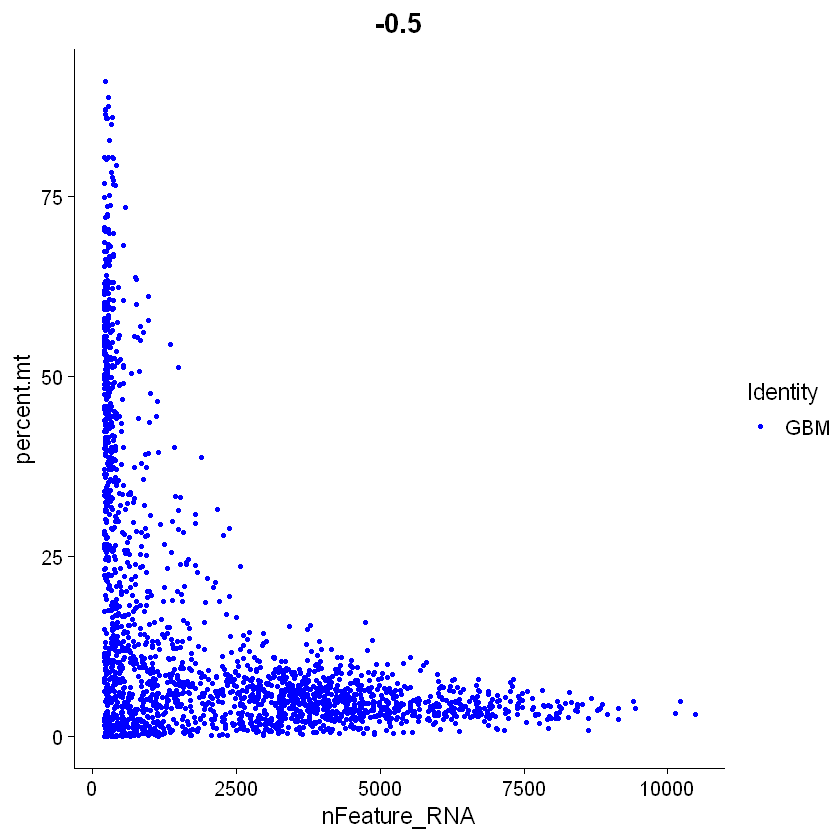

In [9]:
scatt2 <- FeatureScatter(gbm.seurat.obj, feature1 = "nFeature_RNA", feature2 = "percent.mt", cols = "blue")
scatt2

> **3. nFeature_RNA vs  percent.rb**

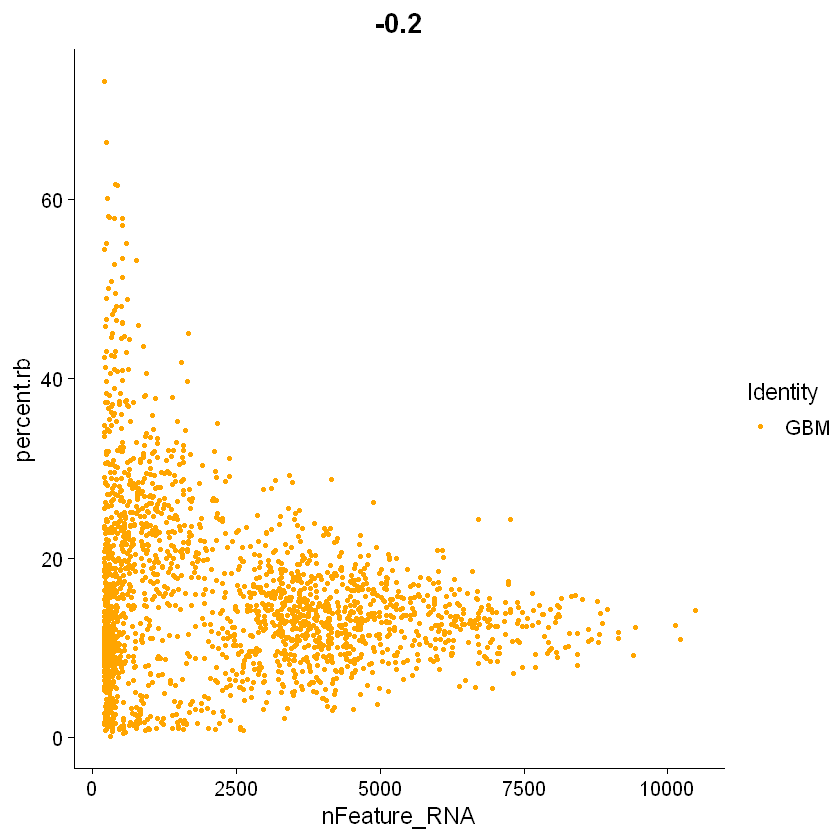

In [10]:
scatt3 <- FeatureScatter(gbm.seurat.obj, feature1 = "nFeature_RNA", feature2 = "percent.rb", cols = "orange")
scatt3

> **4. percent.mt vs percent.rb**

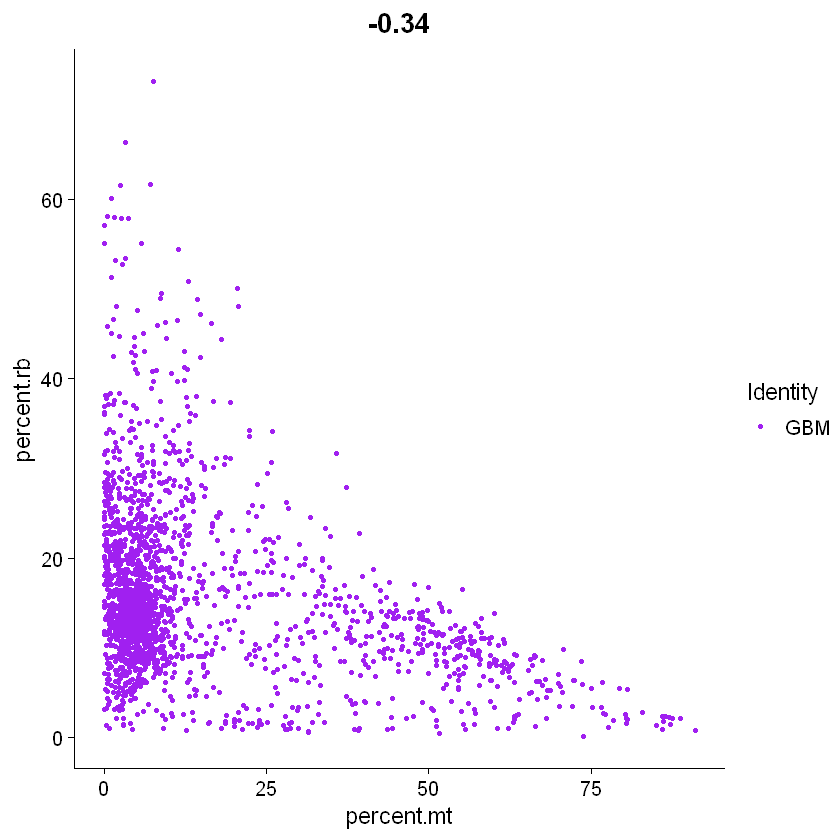

In [11]:
scatt4 <- FeatureScatter(gbm.seurat.obj, feature1 = "percent.mt", feature2 = "percent.rb", cols = "purple")
scatt4

#### <span style="color:maroon; font-weight:bold;">6.1.3 QC metrics stats</span>

In [12]:
#QC metrics stats (Below numbers set based on the distribution of QC metrics (Violin plots) and mutiple iterations with cutoffs)

#Unique features per cell greater than 6500
print(sum(gbm.seurat.obj@meta.data$nFeature_RNA > 6500))
#Unique features per cell less than 200
print(sum(gbm.seurat.obj@meta.data$nFeature_RNA < 200))
#Unique features per cell less than 6500 and greater than 200
print(sum(gbm.seurat.obj@meta.data$nFeature_RNA < 6500 & gbm.seurat.obj@meta.data$nFeature_RNA > 200))
# percent.mt reads per cell less than 20
print(sum(gbm.seurat.obj@meta.data$percent.mt > 20))
# percent.rb reads per cell greater than 25
print(sum(gbm.seurat.obj@meta.data$percent.rb > 25))

#Number of cells could be filtered with respective QC metrics cutoffs
print(sum(gbm.seurat.obj@meta.data$nFeature_RNA < 6500 & gbm.seurat.obj@meta.data$nFeature_RNA > 200 & gbm.seurat.obj@meta.data$percent.mt < 20 & gbm.seurat.obj@meta.data$percent.rb < 25))

[1] 121
[1] 1
[1] 1957
[1] 482
[1] 272
[1] 1221


#### <span style="color:maroon; font-weight:bold;">6.1.4 Interpretation and Inference - visualisation and statistics of QC metrics</span>

> Based on the visulisation, QC metrics statistics and as well as literature survey, it is evident that the cells of GBM are signficantly different from healthy cells, with respect to the considered factors and hence the similar standard cutoffs for QC metrics to filter the cells cannot be applied here. 

> **Decision on cutoffs**

> **1. nFeature_RNA:**
    
    Based on the distribution in the violin plots, it is observed that the cells doesn't follow typical distribution pattern and they are widely distributed here. Also considering the median value for features (>3000) and as well as QC metrics statistics, cells higher than 6500 and less than 200 features were considered to be discarded. This is in contrast to standard cutoffs being set for healthy cells as it is known that cancer cells, especially in GBM, cells have altered gene expression patterns. 

***Reference: https://doi.org/10.1097%2FPPO.0000000000000638***

> **2. nCount_RNA:**

    Based on the scatter plot "nFeature_RNA vs nCount_RNA", it is observed and calculated that nFeature_RNA and nCount_RNA are highly correlated (r-squared = 0.93), hence the cutoff was set only for nFeature_RNA.

***Reference: https://github.com/quadbio/scRNAseq_analysis_vignette/blob/master/Tutorial.md#step-2-quality-control:~:text=Due%20to%20the%20correlation%20of%20gene%20number%20and%20transcript%20number%2C%20we%20only%20need%20to%20set%20a%20cutoff%20to%20either%20one%20of%20these%20metrics***

> **3. percent.mt(% MT):**

    Based on the distribution as in the violin plots, it is observed that these cells doesn't follow typical distrubution pattern as in the healthy cells and it is evident that the GBM cells have higher mtRNA expression levels. As per the biological significance as well, generally GBM cells have higher mtRNA expression to support for for longer survival, reduced tumor aggressiveness, and lower cell differentiation. Hence, a higher cutoff of 20% for mt.percent was chosen. Also, as per the scatter plots, "nFeature_RNA vs mt.percent" and "mt.percent vs rb.percent", it is observed and calculated that mt.percent is not correlated with any of these metrics and hence an independent cutoff was chosen. 

***Reference: https://www.nature.com/articles/s41590-022-01215-0#:~:text=more%20than%2020%25%20mitochondrial%20UMI%20(dying%20cells).***

> **4. percent.rb(% RB):**

    Based on the distribution as in the violin plots, it is observed that these cells doesn't follow typical distrubution pattern as in the healthy cells and it is evident that the cancer cells have higher rRNA expression levels. As per the biological significance as well, generally cancer cells (GBM cells as well) have higher rRNA expression to meet the demands of protein synthesis, which is linked to cell growth and division. Hence, a higher cutoff of 25% for mt.percent was chosen (based on the distribution (violin plots) as well). Also, as per the scatter plots, "nFeature_RNA vs rb.percent" and "mt.percent vs rb.percent", it is observed and calculated that rb.percent is not correlated with any of these metrics and hence an independent cutoff was chosen.

***Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9256764/#:~:text=Owing%20to%20their%20uncontrollable%20proliferation,Ribosomal%20proteins%20undergo%20posttranslational%20modifications.***


> ***As explained above, the QC metrics cutoffs were chosen based on the inference obtained from the visualisation and stats, without following the standard cutoffs of healthy cells. Also, it is recommended by many that is right to exclude only the outliers, without loosing too many cells at the QC step itself, hence stringent cutoffs were not set.***




    

#### <span style="color:maroon; font-weight:bold;">6.1.5 Filtering of cells based on the QC metrics cutoffs</span>

In [13]:
#Quality filtering based on the QC metrics cutoffs
gbm.seurat.obj <- subset(gbm.seurat.obj, subset = nFeature_RNA > 200 & nFeature_RNA < 6500 & percent.mt < 20 & percent.rb < 25)
#View Seurat object
View(gbm.seurat.obj)

An object of class Seurat 
21648 features across 1221 samples within 1 assay 
Active assay: RNA (21648 features, 0 variable features)
 1 layer present: counts

> ***Post-quality filtering based on the QC metrics cutoffs, a total of 1221 cells were leftover.***

### <span style="color:OrangeRed; font-weight:bold;">6.2 Normalization</span>

> **Data normalization is needed to remove technical variation while preserving biological variation before downstream processing. Similar to bulk RNA-seq, the amount of captured RNA is different from cell to cell, and one should therefore not directly compare the number of captured transcripts for each gene (feature) between cells. A normalization step, aiming to make gene expression levels between different cells comparable is necessary. Normalisation accounts for the technical bias such as sequencing depth.**

> **Normalization steps:**

    1. Divide the raw UMI count for each feature by the total detected RNAs (UMI) in each cell.
    2. Multiply by a scaling factor, preferably here it is 10000.
    3. Add a pseudo-count, typically 1, to account for log transformation in the next step, specifically in case of features with zero reads.
    4. Perform a log transformation

>> All these steps are performed by exploiting "NormalizeData()" function of Seurat library.

In [ ]:
#Normalization of feature expression measurements for each cell
gbm.seurat.obj <- NormalizeData(gbm.seurat.obj, normalization.method = "LogNormalize", scale.factor = 10000, verbose = TRUE)
#View seurat.object
View(gbm.seurat.obj)
str(gbm.seurat.obj@commands)

### <span style="color:OrangeRed; font-weight:bold;">6.3 Feature Selection - Detection of Highly Variable Features Between Cells</span>

> To leverage the advantage of scRNA-seq, especially in cancer samples, which is the potential opportunity to look into cellular heterogeneity in a sample, by looking for cell groups with distinct molecular signatures, it is imperative to perform a proper feature selection before further exploration. Here it is termed as the identification of highly variable features/genes, which are genes with the most varied expression levels across cells (highly expressed in some cells, and lowly expressed in others). Seurat tool developers quoted and validated that focusing on the highly variable features in downstream analysis helps to highlight biological signal in single-cell datasets.

> **Here the Feature Selection process is perfomed by exploiting "FindVariableFeatures()" function of Seurat library. FindVariableFeatures() function finds the highly variable featured by modelling the mean-variance relationship. Here Variance Stabilizing Transformation (VST) method is used for regressing mean-variance relationship.** 

> ***Based on the visualisation of the positioning of the variable features in the VariableFeatures plot of mean vs Variance, and as well as considering the higher number of features being present in the current sample (21648 features), an approximate value of 3000 was set for identifying the highly variable features (as performed below).***

Finding variable features for layer counts



Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


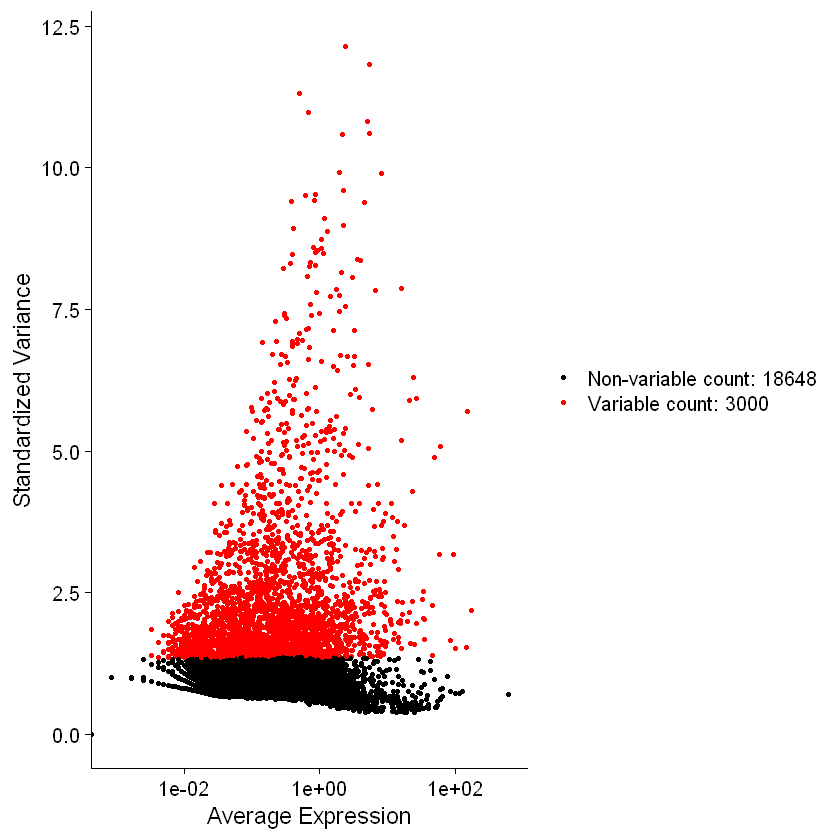

In [15]:
#Identification of variable features using FindVariableFeatures() function 
gbm.seurat.obj <- FindVariableFeatures(gbm.seurat.obj, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

## plot variable features with and without labels
var_feat_plot <- VariableFeaturePlot(gbm.seurat.obj)
var_feat_plot


Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


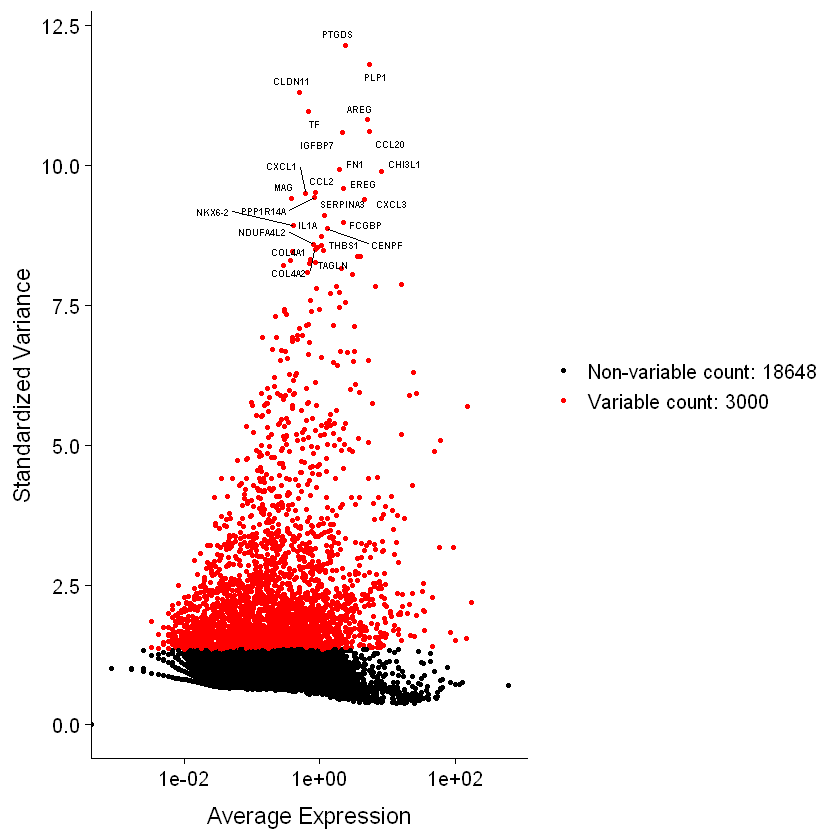

In [16]:
#Append the top 25 highly variable features into a variable
top25_var_feat <- head(VariableFeatures(gbm.seurat.obj), 25)

## plot variable features with and with labels
var_feat_plot_label <- LabelPoints(plot = var_feat_plot, points = top25_var_feat, repel = TRUE, 
                                   max.overlaps = 25, xnudge = 0, ynudge = 0, size = 2, fontface = "bold")
var_feat_plot_label

In [17]:
#Top 25 highly variable features
top25_var_feat

[1] "PTGDS"    "PLP1"     "CLDN11"   "TF"       "AREG"     "CCL20"   
 [7] "IGFBP7"   "FN1"      "CHI3L1"   "EREG"     "CCL2"     "CXCL1"   
[13] "PPP1R14A" "MAG"      "CXCL3"    "SERPINA3" "FCGBP"    "NKX6-2"  
[19] "CENPF"    "IL1A"     "NDUFA4L2" "THBS1"    "COL4A1"   "COL4A2"  
[25] "TAGLN"

### <span style="color:OrangeRed; font-weight:bold;">6.4 Data Scaling - Linear Transformation</span>

> Scaling the data or linear transformation prior to performing dimensionality reduction such as PCA etc. is well known and a standard pre-processing step. Since different genes have different base expression levels and distributions, the contribution of each gene to the downstream analysis is different if no data transformation is performed. This is something which is highly recommended to be avoided as otherwise the entire downstream analysis would only depend on genes/features that are highly expressed. This is because highly expressed genes exhibit the highest amount of variation and we don’t want our ‘highly variable genes’ only to reflect high expression. Hence scaling the data using selected features is perfomed.

> **Here the data scaling is performed by exploiting ScaleData() function available in the Seurat library. The ScaleData() fucntion transforms the data the following way:**

    1. Adjust the expression of each feature so that the average expression level across all cells becomes zero.
    2. Standardizes the expression of each feature so that the variance across cells is normalized to 1. (This process ensures that highly expressed genes do not disproportionately influence subsequent downstream analyses by assigning them equal importance.)

> ***By default ScaleData() function transforms only the pre-selected highly variable features. But here scaling is performed for all the features.***

In [18]:
#Append all the feature names from the seurat object into a variable
all.features <- rownames(gbm.seurat.obj)

#Data Scaling using ScaleData() function for all the features available in the Seurat object
gbm.seurat.obj <- ScaleData(gbm.seurat.obj, features = all.features, verbose = TRUE)

Centering and scaling data matrix



> ***Experts view on regressing out unwanted sources of variation such as cell cycle related variables, mitochondrial reads percentage etc.***

    As mentioned, the process of regressing out variables dramatically slows down the whole process, and it is not clear that the result will be satisfactory as the unwanted variation may be far from linear. Therefore, a common suggestion is not to perform any regress-out in the first iteration of data exploration, but first check the result, and if any unwanted source of variation dominates the cellular heterogeneity, try to regress out the respective variable and see whether the result improves. Hence, this process of regressing out these variables is bypassed for now.

***Reference: https://github.com/quadbio/scRNAseq_analysis_vignette/blob/master/Tutorial.md#step-2-quality-control:~:text=Variables%20which%20are,the%20result%20improves.***




## <span style="color:blue; font-weight:bold;">7. Linear Dimensionality Reduction - Principal Component Analysis (PCA)</span>

> After identifying highly variable features and scaling the data, applying a linear dimension reduction before performing any further downstream analyses will aid in understanding the heterogeneity of the tumor sample by clustering the cells and identifying the patterns of variation among the cells by undertaking the criteria of preserving the global structure of the dataset. Also, performing PCA will help in understanding the dimensionality of the dataset which will be beneficial in performing a lot of downstream analyses. 

> **To perform principal component analysis, RunPCA() function available in the Seurat library is exploited. To perform the principal component analysis, by default and as recommended, previously modelled and calculated highly variable genes are used as input.**

> ***Initially, for now, 50 Principal Components (PCs) are calculated.***

In [19]:
#Linear Dimensionality Reduction by calculating 50 PCs
gbm.seurat.obj <- RunPCA(gbm.seurat.obj, features = VariableFeatures(object = gbm.seurat.obj), npcs = 50)

PC_ 1 
Positive:  NOVA1, GPM6B, PTN, TUBB2B, PTPRZ1, TUBA1A, SEC61G, C1orf61, SOX2, CKB 
	   MARCKSL1, EGFR, IGFBP2, GPM6A, FABP7, PMP2, CDH2, BCAN, GRIA2, MAP2 
	   METRN, SOX2-OT, SCRG1, RCN2, SCG3, RHOBTB3, DSEL, CNN3, MDK, TRIM9 
Negative:  SRGN, CD74, HLA-DRA, HLA-DPA1, HLA-DPB1, HLA-DRB5, LAPTM5, CYBA, IFI30, FCER1G 
	   C1QB, C1QA, C1QC, AIF1, HLA-DRB1, HLA-DMA, RNASET2, SAT1, MS4A7, CTSS 
	   OLR1, CD83, CTSZ, NPC2, PLEK, FCGR3A, BCL2A1, ALOX5AP, FCGR2A, CD14 
PC_ 2 
Positive:  VIM, CST3, IGFBP2, EGFR, FABP7, PTPRZ1, CHL1, FABP5, SEC61G, LUZP2 
	   BCAN, TMEM158, MDK, FOXG1, TRIB2, NR2F1, CCND2, ID4, SOX4, MAP2 
	   CDH2, ETV1, CNN3, GAP43, NR2F2, BCHE, PKIB, ODC1, EDNRB, TIMP3 
Negative:  CLDN11, EDIL3, TF, MAG, MAP7, ERMN, NKX6-2, CNTN2, ANKS1B, MOG 
	   ENPP2, CNDP1, TMEM144, CARNS1, PLP1, KLK6, EFHD1, ABCA2, SLC24A2, PTGDS 
	   HAPLN2, MYRF, GPR37, RAPGEF5, SPOCK3, TMEM151A, TPPP, PLEKHH1, PPP1R14A, CAPN3 
PC_ 3 
Positive:  NEAT1, RHOB, SOCS3, ZFAND5, FOS, PPP1R15A, KLF6, G

### <span style="color:OrangeRed; font-weight:bold;">7.1 Scree Plot</span>

> ***Right after Principal Component Analysis (PCA), it is always recommended to depict the scree plot to observe the dataset variance distribution across the principal components (PCs). Here it gives a general view over which PC or number of PCs accounting the variation pattern and heterogeneity.***

>> The scree plot is generated using ElbowPlot() function available in the Seurat library.

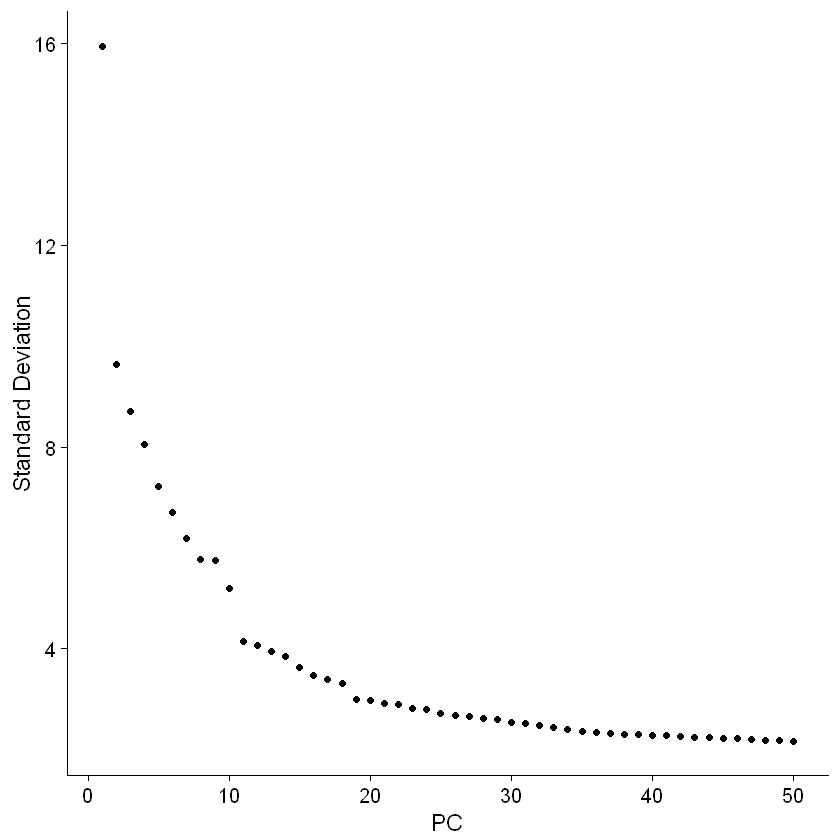

In [20]:
#Scree plot visualisation
ElbowPlot(gbm.seurat.obj, ndims = ncol(Embeddings(gbm.seurat.obj, "pca")))

> ***As depicted above, it is observed that the top 35 PCs are accounting for the maximum amount of the variance (~>90%) explained and the second phase of the elbow flatten after 35th PC. Further exploration of these top 35 PCs on the basis of individual contribution to explain the heterogeneity and feature loadings is suitable before proceeding further with finalising the dimensionality of the dataset.***

> Along with generation of PCs, PCA outputs the gene/feature modules of positive and neagtive loadings for each PC. 
>> Each principal component represent a direction in the HD gene expression space.

    1. Positive Loadings: Features in this module, contribute positively to the direction of variation for that PC in the HD gene expression space. These features are positively correlated across the cells.
    2. Negative Loadings: Features in this module, contribute negatively to the direction of variation for that PC in the HD gene expression space. These features are negatively correlated across the cells.

In [21]:
#Examine the top 5 features in positive and negative feature/gene modules of all the PCs | "PCA output/result is stored in the embedding called {'pca'}"
print(gbm.seurat.obj[["pca"]], dims = 1:50, nfeatures = 5)

PC_ 1 
Positive:  NOVA1, GPM6B, PTN, TUBB2B, PTPRZ1 
Negative:  SRGN, CD74, HLA-DRA, HLA-DPA1, HLA-DPB1 
PC_ 2 
Positive:  VIM, CST3, IGFBP2, EGFR, FABP7 
Negative:  CLDN11, EDIL3, TF, MAG, MAP7 
PC_ 3 
Positive:  NEAT1, RHOB, SOCS3, ZFAND5, FOS 
Negative:  TMIGD3, CD2, CD3E, TRBC2, GZMA 
PC_ 4 
Positive:  MYO1B, ITGA1, PDLIM1, GGT5, GNG11 
Negative:  HES6, OLIG2, DLL3, SOX8, TCF12 
PC_ 5 
Positive:  CCL5, IL32, GZMA, TRBC2, NUSAP1 
Negative:  LGALS3, CST3, CLU, CHI3L1, FTL 
PC_ 6 
Positive:  CD44, TUBA4A, ISG20, ANXA1, CD52 
Negative:  TMIGD3, GPR34, APOC2, A2M, LINC01736 
PC_ 7 
Positive:  NUSAP1, TOP2A, UBE2C, DLGAP5, TTK 
Negative:  TNR, FERMT1, AC009041.2, ATCAY, DLL3 
PC_ 8 
Positive:  NAV3, CX3CR1, RGS16, BHLHE41, TMEM119 
Negative:  LYZ, C15orf48, SLC16A10, THBD, TGFBI 
PC_ 9 
Positive:  CLDN5, VWF, MMP28, ADGRL4, PCAT19 
Negative:  COL1A2, COL3A1, PDGFRB, CD248, ENPEP 
PC_ 10 
Positive:  AKAP12, NDRG1, SLC2A1, ENO2, CA9 
Negative:  CST3, ATP1A2, ATP1B2, AQP4, S100B 
PC_ 11 
Po

### <span style="color:OrangeRed; font-weight:bold;">7.2 Visualize Dimensional Reduction genes - Visualization of top genes associated with reduction components</span>

Visualizing the features across the PCA scores for individual PC gives a better understanding of the contribution of the features to PC in terms of direction of variation. Here it is looked for top 20 features.

>> Performed using VizDimLoadings() function available in the Seurat library.

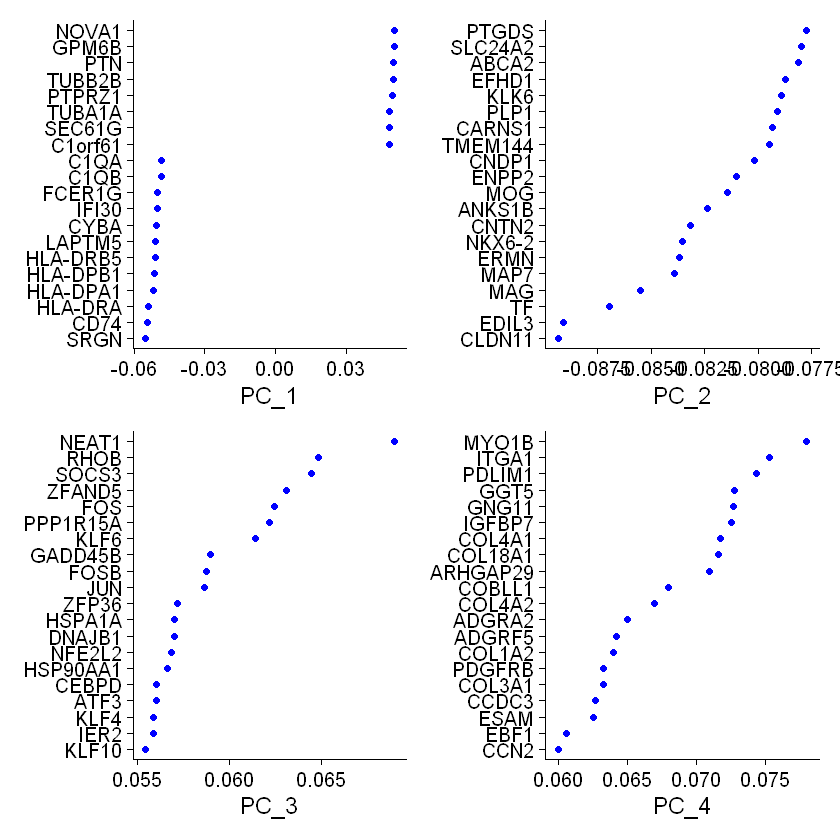

In [22]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 1:4, reduction = "pca", nfeatures = 20, ncol = 2)


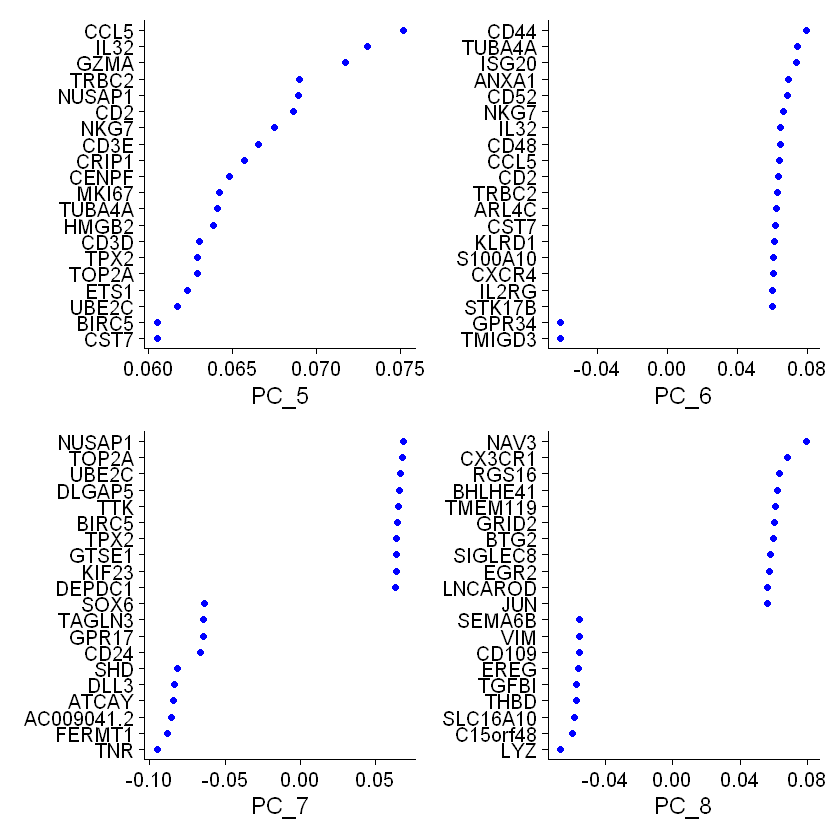

In [23]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 5:8, reduction = "pca", nfeatures = 20, ncol = 2)

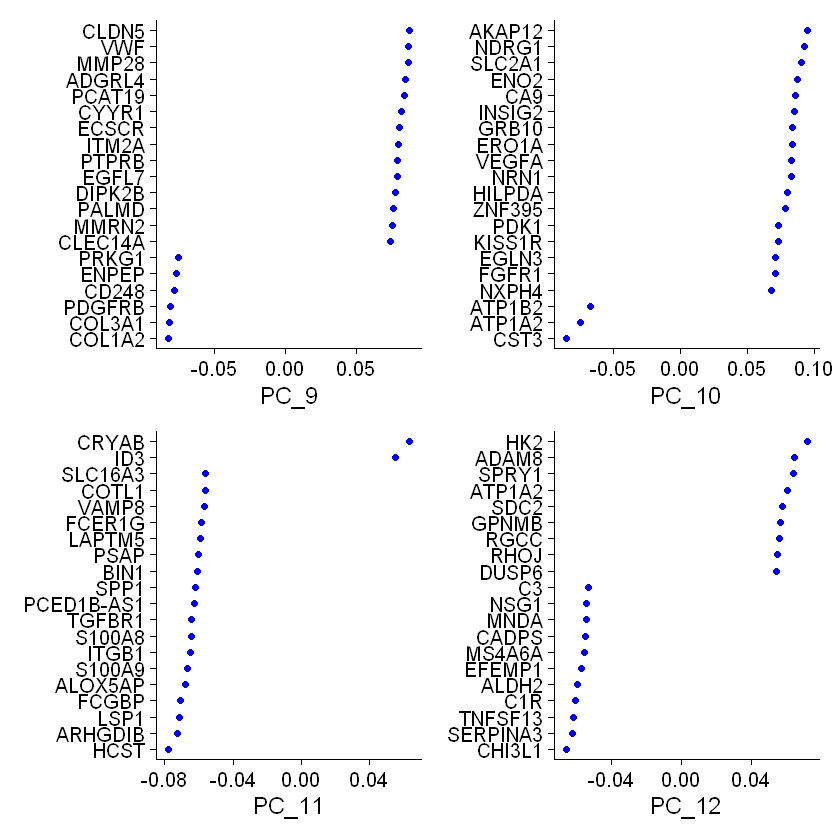

In [24]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 9:12, reduction = "pca", nfeatures = 20, ncol = 2)

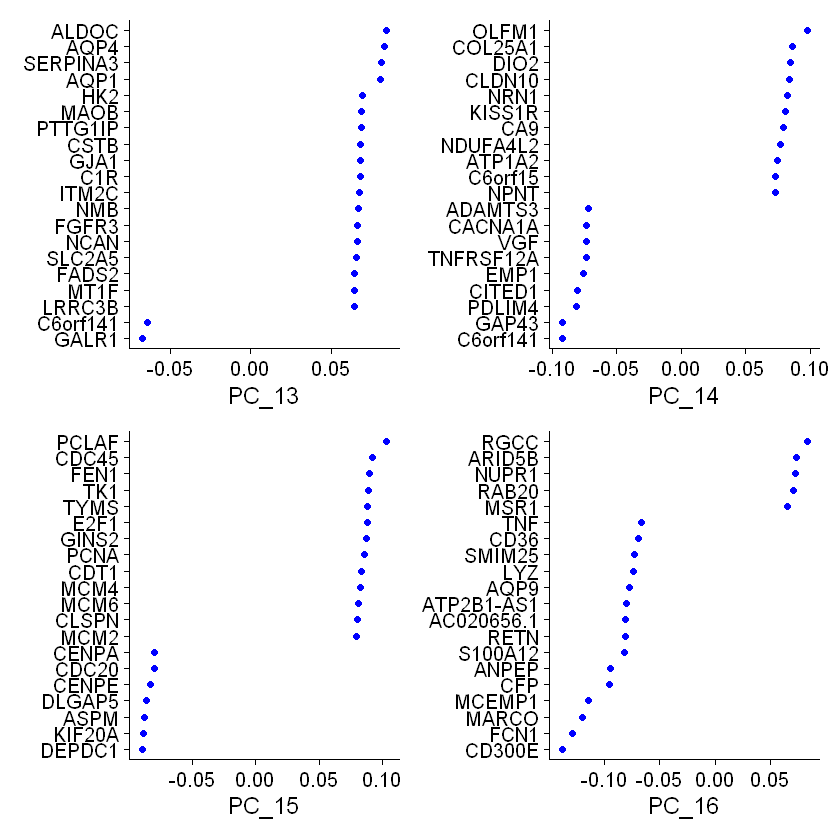

In [25]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 13:16, reduction = "pca", nfeatures = 20, ncol = 2)

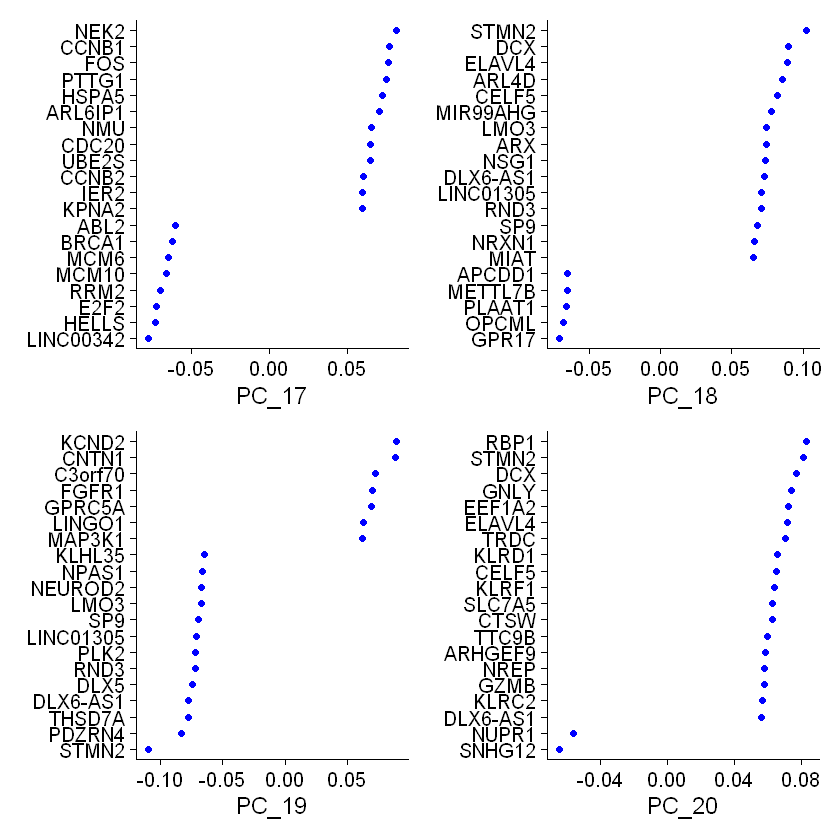

In [26]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 17:20, reduction = "pca", nfeatures = 20, ncol = 2)

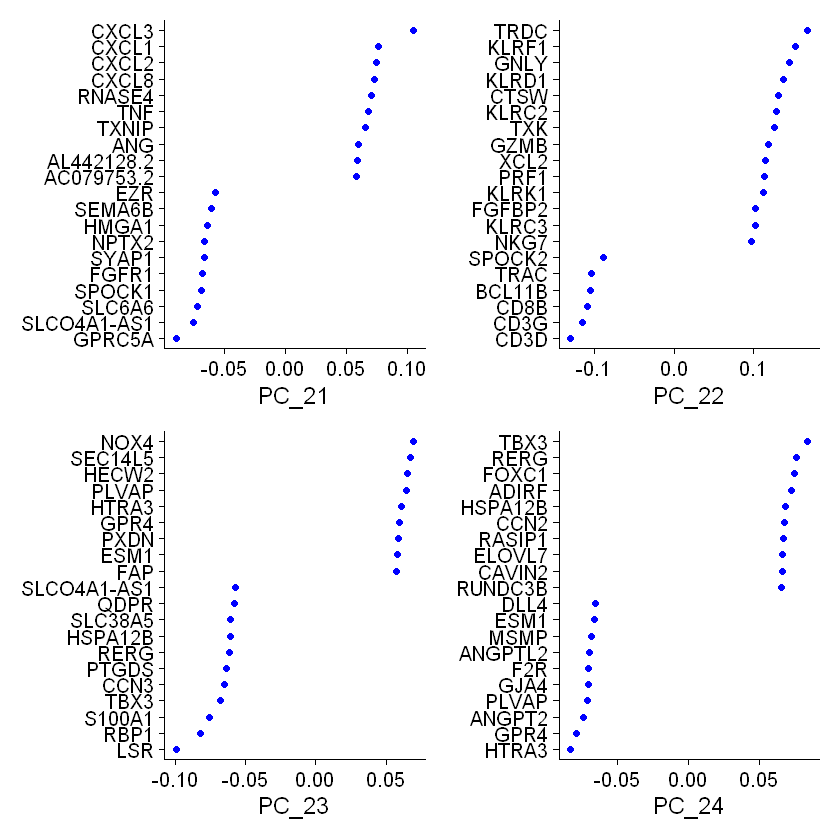

In [27]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 21:24, reduction = "pca", nfeatures = 20, ncol = 2)

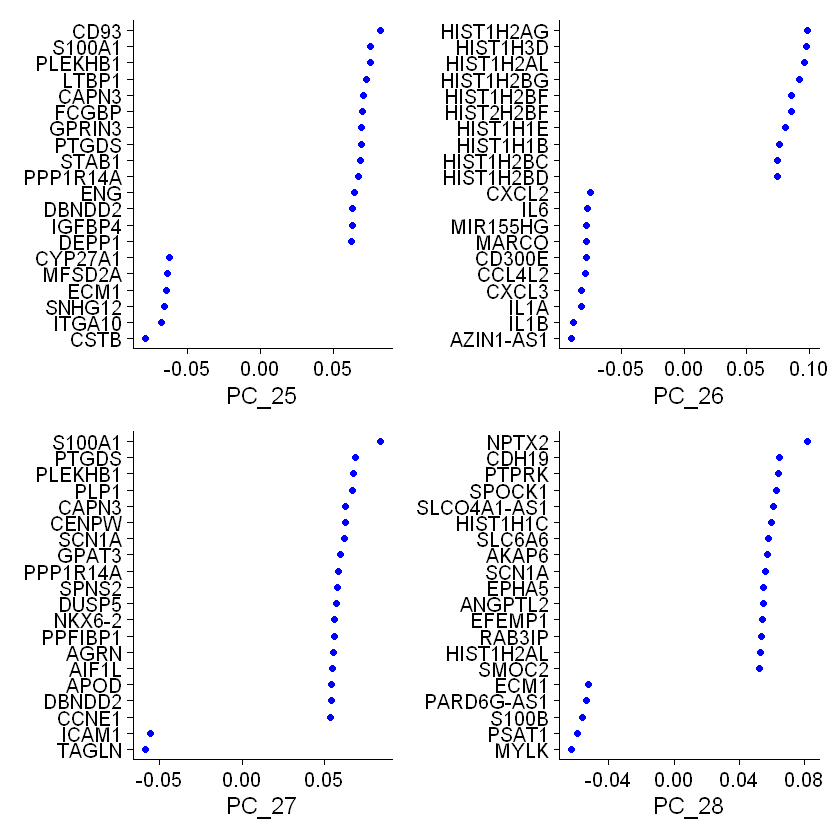

In [28]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 25:28, reduction = "pca", nfeatures = 20, ncol = 2)

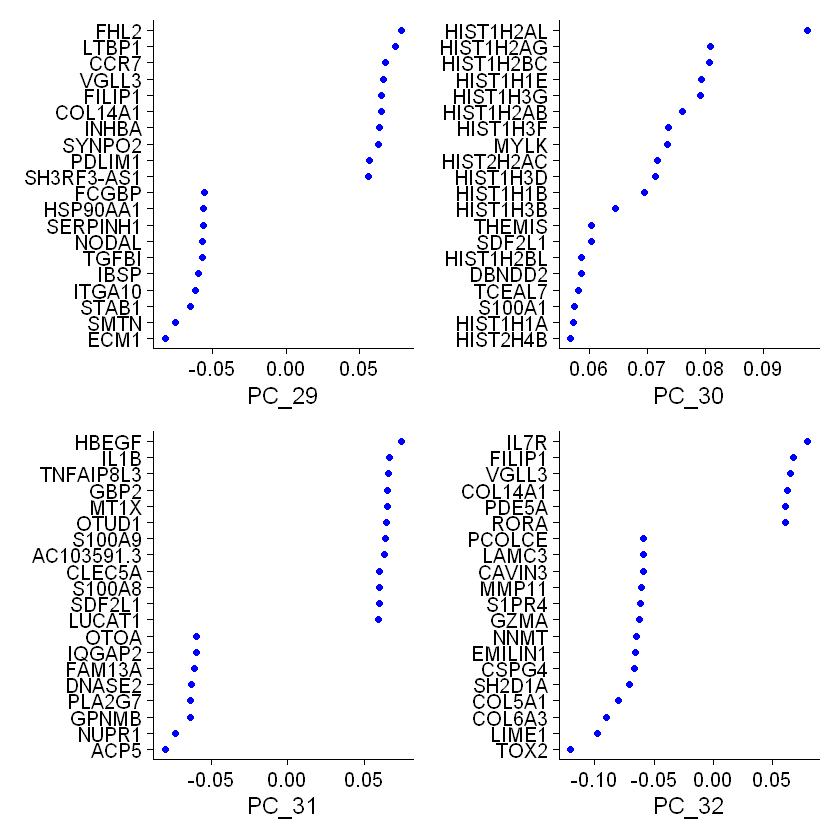

In [29]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 29:32, reduction = "pca", nfeatures = 20, ncol = 2)

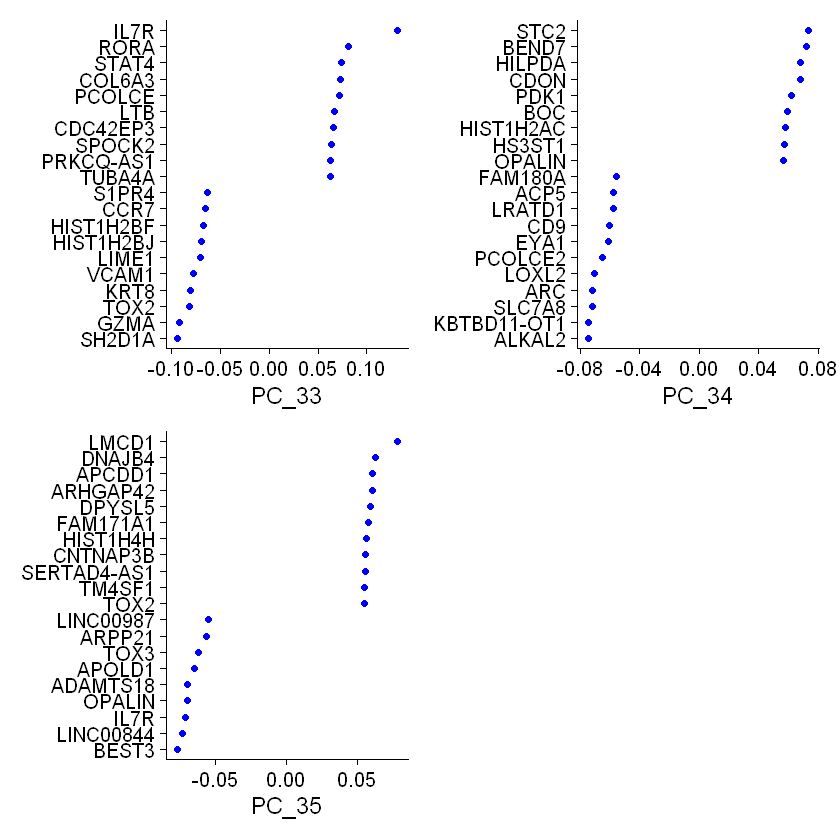

In [30]:
# Generate the plot
VizDimLoadings(gbm.seurat.obj, dims = 33:35, reduction = "pca", nfeatures = 20, ncol = 2)

### <span style="color:OrangeRed; font-weight:bold;">7.3 Heatmap | Feature-Cell PCA scores</span>

> **Representing the selected features (50) equally from both the positive and negative loading modules obtained from PCA on a heatmap across suitable number of cells (500) will help in easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. In the heatmap both cells and features are ordered according to their PCA scores. This way of representing the features across the cells with their respective PCA scores is considered to be a valuable tool for exploring correlated feature sets.**

>> Heatmaps were generated using DimHeatmap() fucntion available in the Seurat library.

> **Heatmap representation of PC_1 for 50 features and 500 cells**

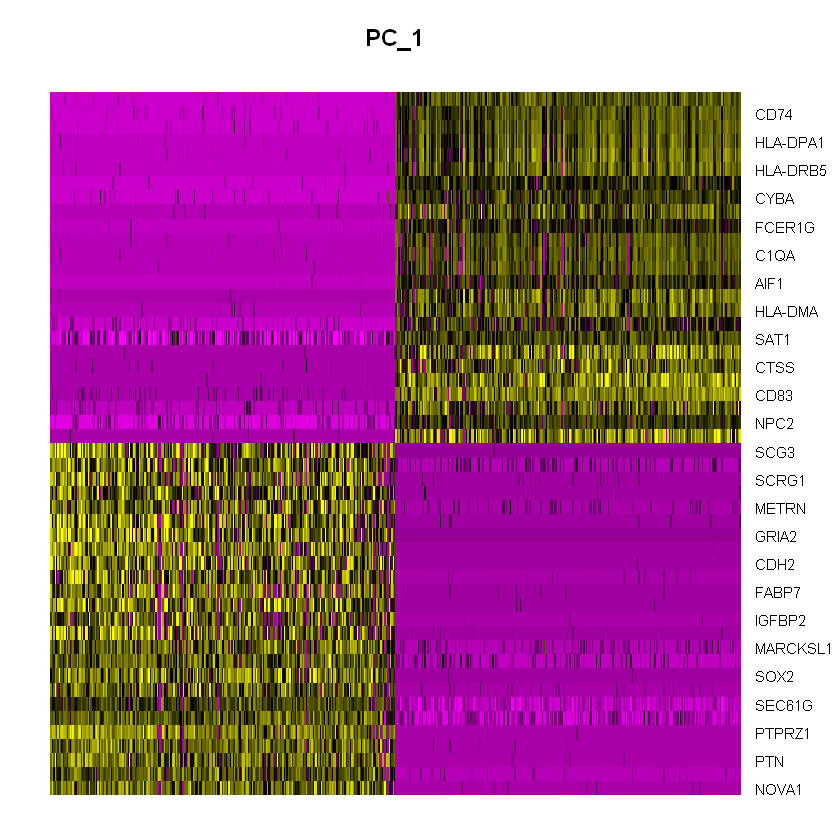

In [31]:
DimHeatmap(gbm.seurat.obj, dims = 1, cells = 500, nfeatures = 50, balanced = TRUE)

> **Heatmap representation of PC_1 for 500 features and 1000 cells**

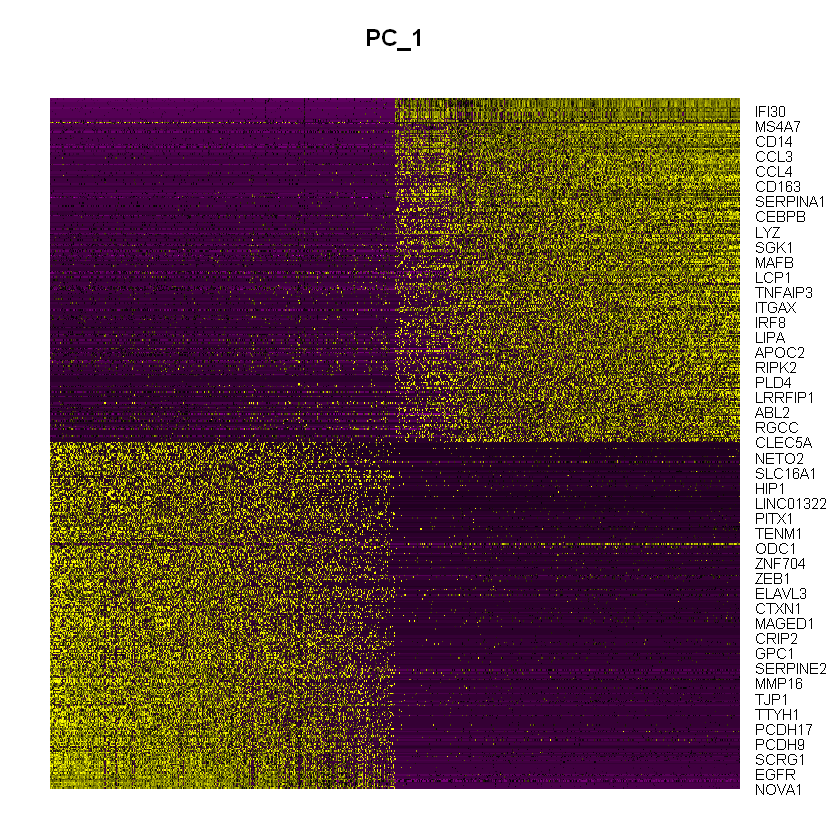

In [32]:
DimHeatmap(gbm.seurat.obj, dims = 1, cells = 1000, nfeatures = 500, balanced = TRUE)

The above heatmaps of PC_1 depicts the variation/heterogeneity accounted by PC_1. When the plotting was done for 50 features and 500 cells, there could be seen that the PCA scores distribution across the cells clearly clustered the cells with similar expression patterns. Subsequently considering 500 features and 1000 cells, it could be clearly infered that PC_1 is accounting for the maximum amount of variation and explains the heterogeneity patterns with significance.

Similarly, the variation patterns and heterogeneity explained by the rest of the 34 PCs is examined below;

> **Heatmap representation of PC_2 to PC_7 for 50 features and 500 cells**

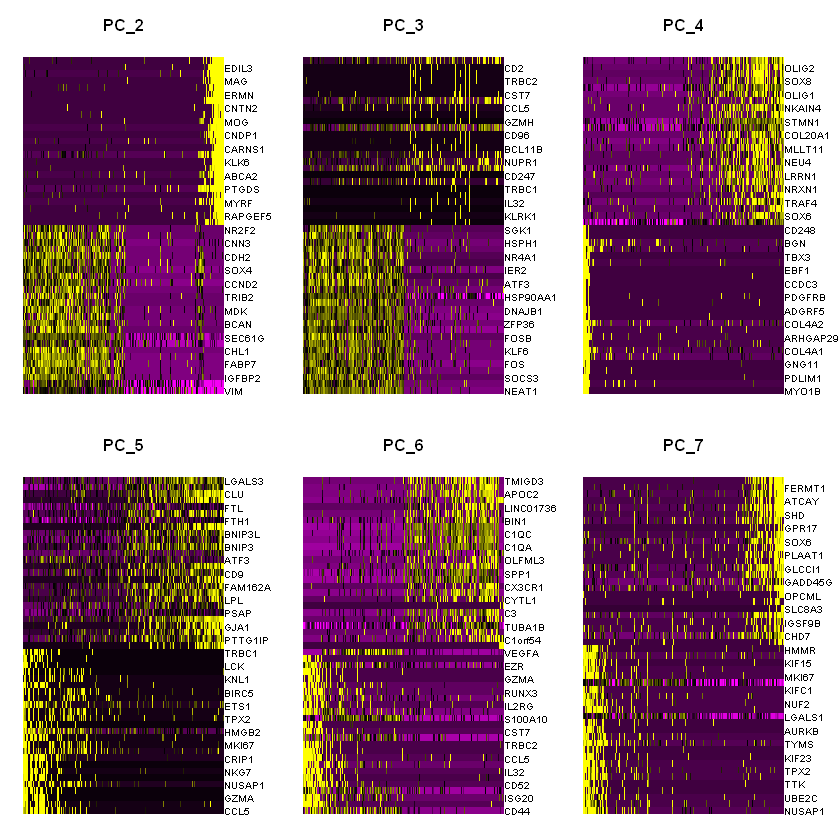

In [33]:
DimHeatmap(gbm.seurat.obj, dims = 2:7, cells = 500, nfeatures = 50, balanced = TRUE)

> **Heatmap representation of PC_8 to PC_13 for 50 features and 500 cells**

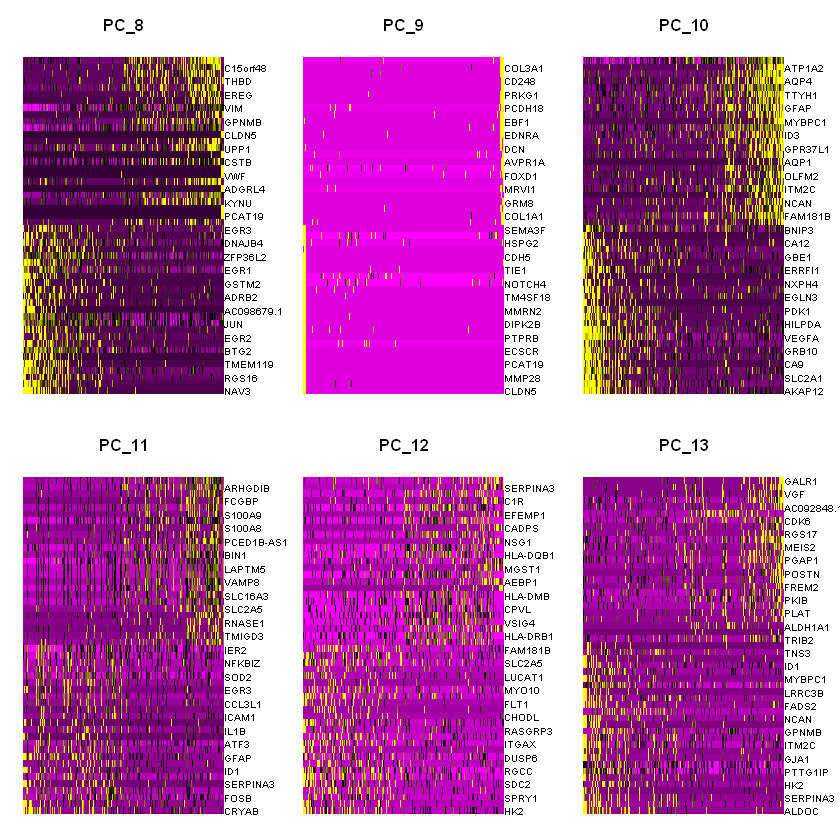

In [34]:
DimHeatmap(gbm.seurat.obj, dims = 8:13, cells = 500, nfeatures = 50, balanced = TRUE)

> **Heatmap representation of PC_14 to PC_19 for 50 features and 500 cells**

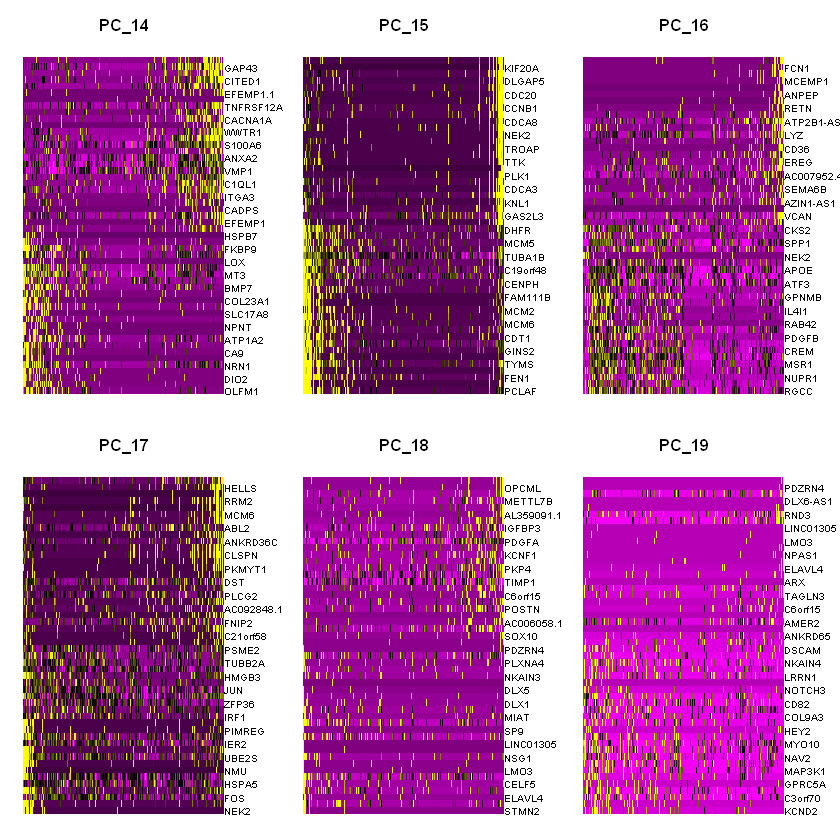

In [35]:
DimHeatmap(gbm.seurat.obj, dims = 14:19, cells = 500, nfeatures = 50, balanced = TRUE)

> **Heatmap representation of PC_20 to PC_25 for 50 features and 500 cells**

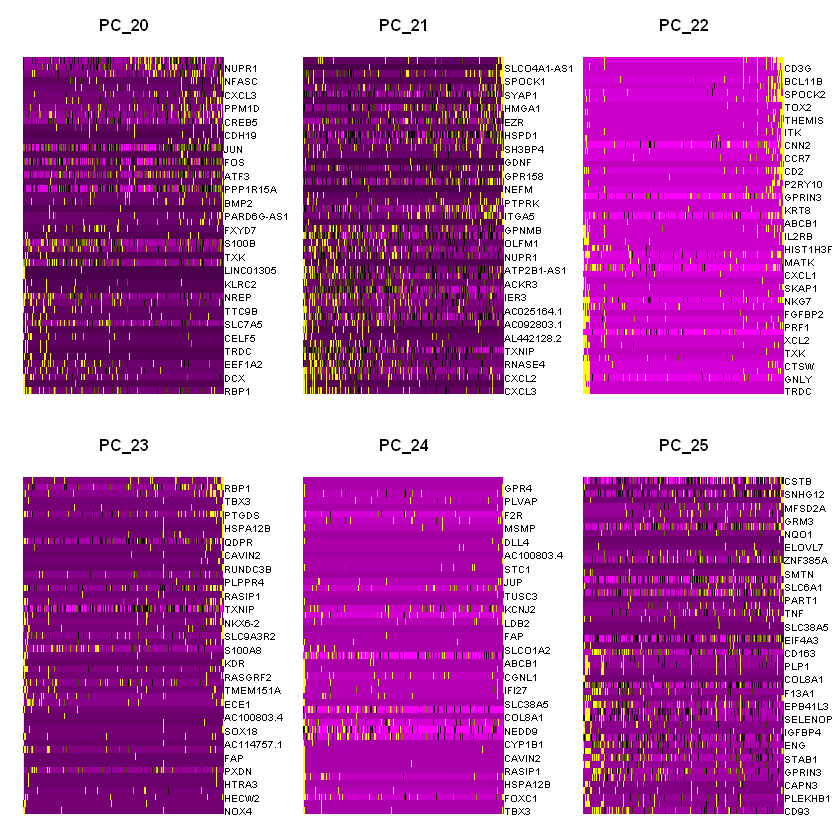

In [36]:
DimHeatmap(gbm.seurat.obj, dims = 20:25, cells = 500, nfeatures = 50, balanced = TRUE)

> **Heatmap representation of PC_26 to PC_31 for 50 features and 500 cells**

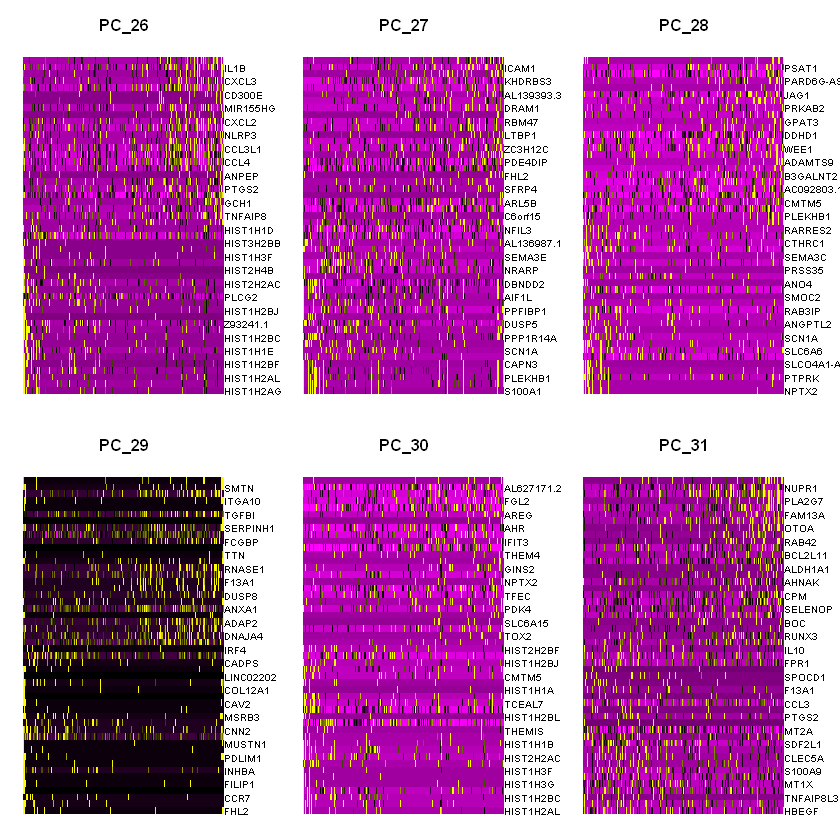

In [37]:
DimHeatmap(gbm.seurat.obj, dims = 26:31, cells = 500, nfeatures = 50, balanced = TRUE)

> **Heatmap representation of PC_32 to PC_35 for 50 features and 500 cells**

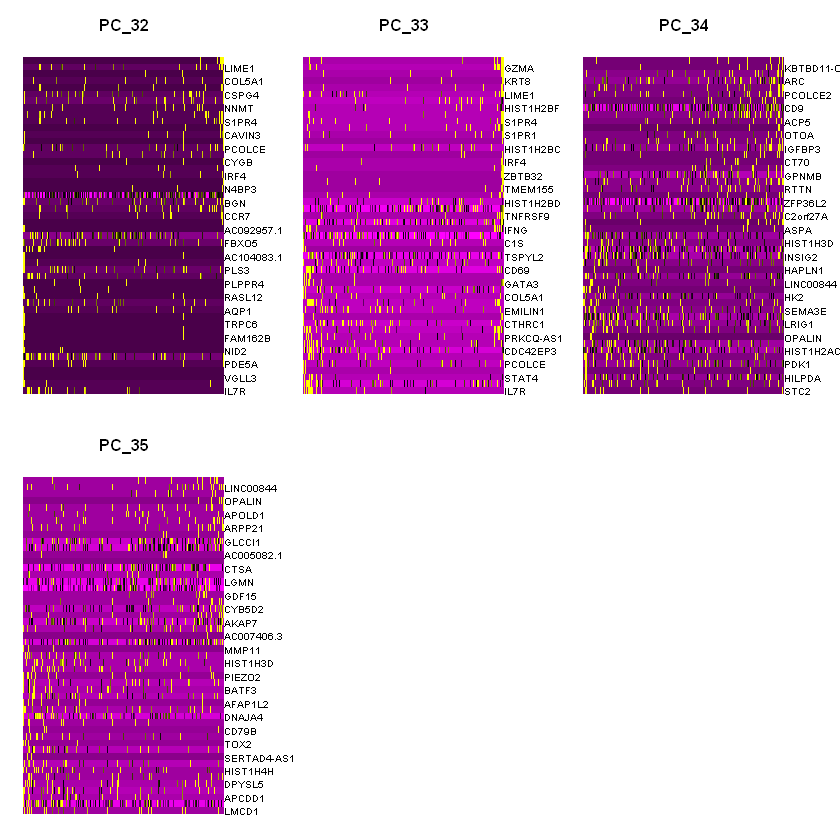

In [38]:
DimHeatmap(gbm.seurat.obj, dims = 32:35, cells = 500, nfeatures = 50, balanced = TRUE)

> **Based on the close observation of the heatmaps representing respective PCs displayed the following:**

    1. The intital top PCs i.e., PC_2 to PC_7 accounted for a considerable amount of variance and clustered the cells accordingly, explaining heterogeneity significantly.
    2. PC_8 to PC_25, explained the variation patterns minimal than that of the top ones, but a suitable cell clusters across the features was observed. 
    3. The rest of the PCs til PC_35 accounted for a little variation but considering these would be valid for optimal clustering of cells. 

> **All in all, the chosen 35 PCs significantly explains the heterogeneity and feature expression variation patterns and hence clustering of all the cells based on these 35 PCs will be precise to understand the strucutre and composition of the chosen sample**

## <span style="color:blue; font-weight:bold;">8. "Dimensionality" of the dataset</span>

> **Based on PCA, with mutiple assessments done to understand the background of the PCs in terms of explaining the feature expression variation patterns and sample heterogeneity, we could finalise that top 35 PCs account for maximum variance (~>90%) (as explained in the scree plot) and beleive that these 35 PCs should be significantly enough to explain the concept of cell heterogeneity and aid in clustering of cells in the whole accordingly.**

> **As there in no golden standard rule in terms of shortlisting the PCs to understand the variation patterns and for clustering, it is advised to be on the higher side when choosing this parameter. Because proceeding with lesser number of PCs would hamper the following downstream analyses as the selected PCs would eventually fail in the expalining the maximum variation leading to non-significant results. It is also well known that lower-ranked PCs might have weak signal buried in the noise which might be aiding in clustering. Hence identifying the true dimensionality of a dataset is challenging and requires to be done by looking into mutliple assessments.**

> ***Based on the clear understanding of the parameters and the above mentioned conditions, I proceed with considering top-ranked first 35 Principal Components (PCs) for further downstream analysis***

## <span style="color:blue; font-weight:bold;">9. Cell Clustering</span>

> **To more comprehensively understand the underlying heterogeneity in the data, it is necessary to identify cell groups with an unbiased manner. Hence, cell clustering will aid in grouping the cells of similar characterstics into communities/clusters.**

> **As well known, graph-based community/cluster identification algorithm is implemented here and clustering is driven by the "distance metric"/"Euclidean distance" of PCA space.**


### <span style="color:OrangeRed; font-weight:bold;">9.1 Finding neighbours</span>

> **In this step, a KNN graph is contructed based on the PCA distance mertic wherein the cells with similar feature expression patterns are connected with edges**

>> FindNeighbors() function available in the Seurat library is used here with taking in the input of dimensionality of the dataset i.e., First 35 PCs

In [ ]:
#KNN graph construction
gbm.seurat.obj <- FindNeighbors(gbm.seurat.obj, reduction = "pca", dims = 1:35, verbose = TRUE)
#View seurat object
str(gbm.seurat.obj)

### <span style="color:OrangeRed; font-weight:bold;">9.2 Finding Clusters</span>

> **Once the KNN graph is constructed and modified to form the SNN (Shared Nearest Neighbors), Louvain community identification algorithm is applied to the network to look for clusters in the network.**

> **The most important factor in emphasise on here is the "resolution" parameter. The resolution parameter sets the granulariy of the clustering process. Higher the resoultion, greater number of clusters. Finding the optimal value in aid in the defining the need of whether to cluster the cells based on major characterstics or also based on very finer/minor characterstics. Hence it is recommended to perform the cluster identification step with multiple iterations of different values of resolution. Ideally the resolution ranges between 0.1 and 1**

>> FindClusters() function available in the Seurat library is used here with taking in the user input of resolution parameter

> ***For now, clusters/communities were drawn for a set of reolution values, starting from 0.1 to 1.4. Based on the visualisation and significance of clustering at particular value of resolution, we could proceed further.*** 

In [ ]:
#Identification of clusters for different resolution values
gbm.seurat.obj <- FindClusters(gbm.seurat.obj, resolution = c(0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1, 1.2, 1.4))


> **Clusters identified for individual resolution values - stored in meta.data section of gbm.seurat.obj**

In [41]:
#View the clusters generated by each resolution value stored in the meta.data section of seurat object
head(gbm.seurat.obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,RNA_snn_res.0.1,RNA_snn_res.0.2,RNA_snn_res.0.3,RNA_snn_res.0.4,RNA_snn_res.0.5,RNA_snn_res.0.7,RNA_snn_res.0.9,RNA_snn_res.1,RNA_snn_res.1.2,RNA_snn_res.1.4,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AAACCCACATGTGTCA-1,GBM,15621,2821,10.876384,16.06811,1,1,1,5,4,4,4,4,4,3,3
AAACGAAAGAGAACCC-1,GBM,19897,3501,5.734533,24.25491,1,1,1,2,2,1,1,1,1,1,1
AAACGCTAGATTAGAC-1,GBM,2856,1365,3.781513,19.43277,4,5,6,7,7,7,8,8,8,9,9
AAACGCTGTACGCTAT-1,GBM,31357,4350,6.017795,17.83653,1,4,4,4,3,3,2,2,2,2,2
AAAGAACAGTACAGCG-1,GBM,12634,2778,7.978471,16.03609,1,1,1,2,2,1,1,1,1,1,1
AAAGGATAGATTGTGA-1,GBM,13487,2531,8.489657,23.02217,1,1,1,2,2,1,1,1,1,1,1


> **Visualise clusters identified by individual resolution values**

> ***Resolution = 0.1***

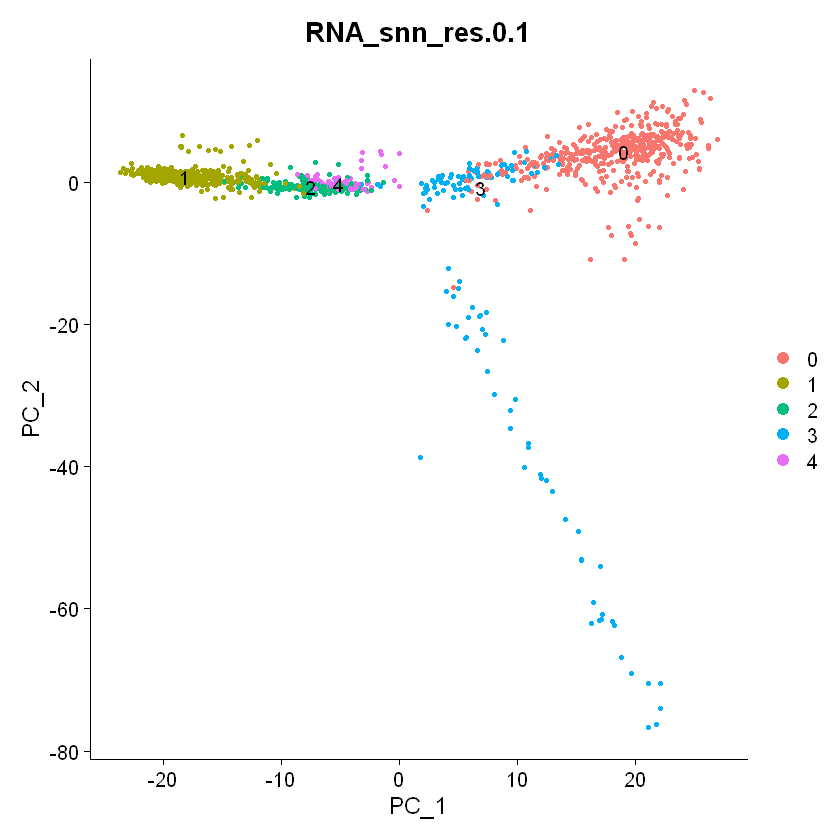

In [42]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.0.1", reduction = "pca", label = TRUE)

> ***Resolution = 0.2***

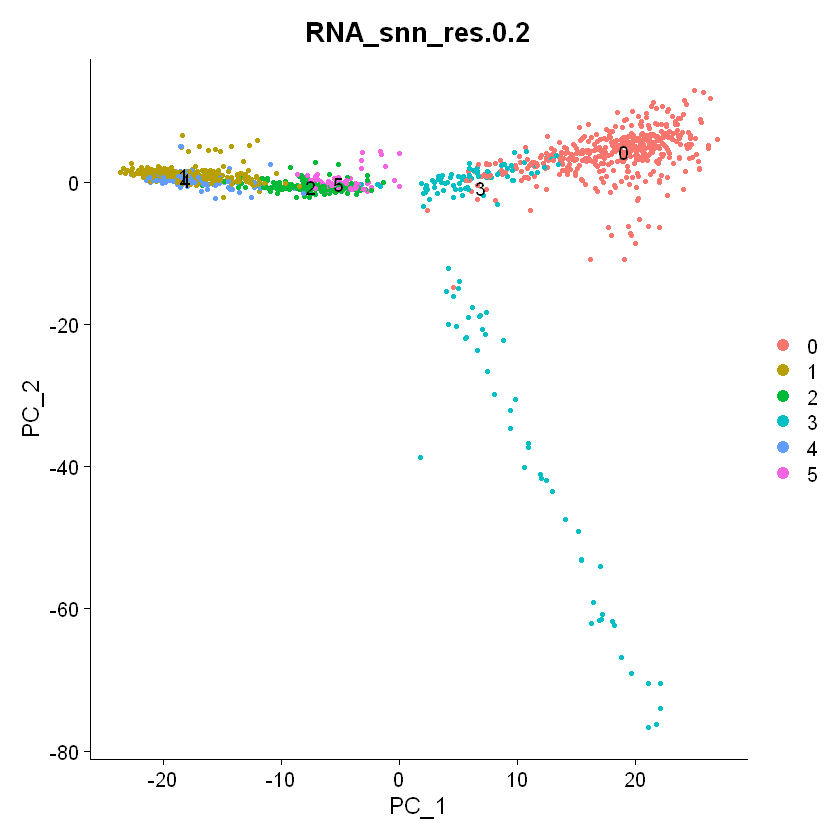

In [43]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.0.2", reduction = "pca", label = TRUE)

> ***Resolution = 0.3***

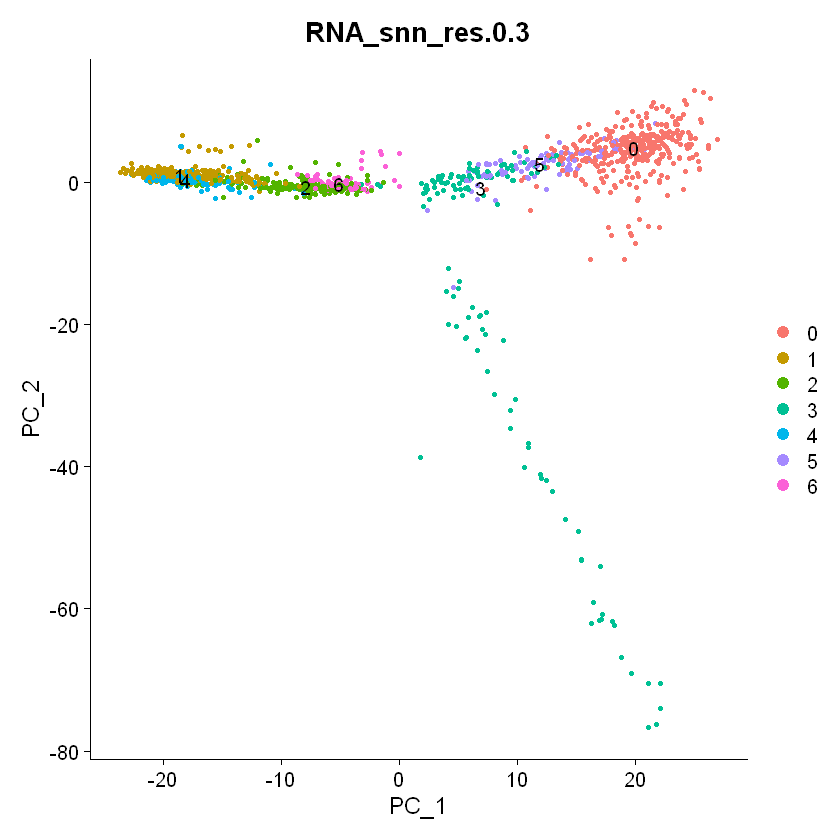

In [44]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.0.3", reduction = "pca", label = TRUE)

> ***Resolution = 0.4***

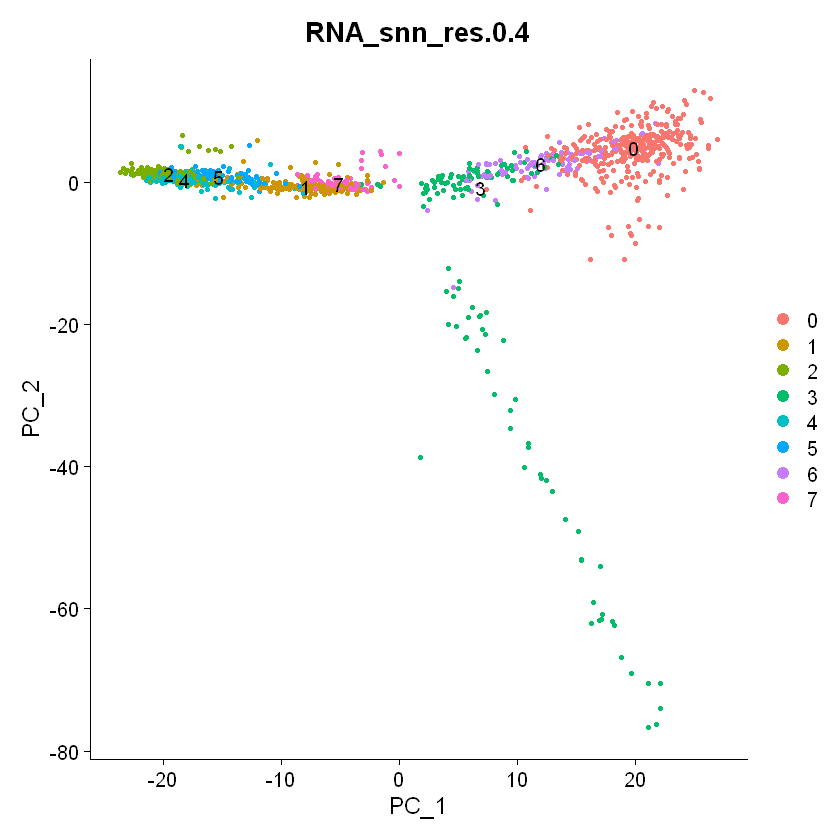

In [45]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.0.4", reduction = "pca", label = TRUE)

> ***Resolution = 0.5***

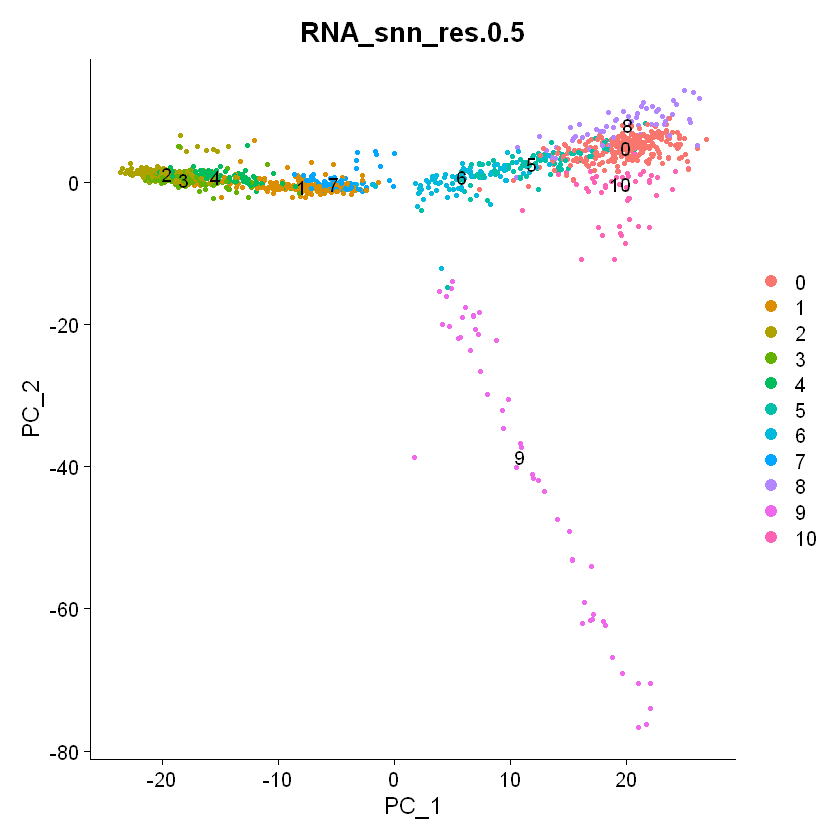

In [46]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.0.5", reduction = "pca", label = TRUE)

> ***Resolution = 0.7***

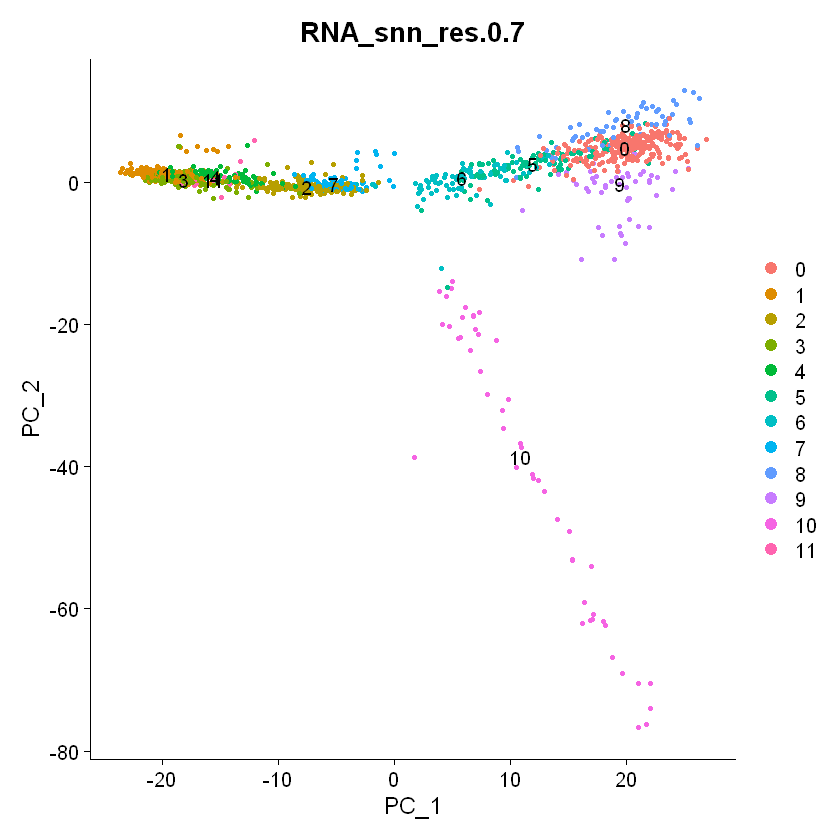

In [47]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.0.7", reduction = "pca", label = TRUE)

> ***Resolution = 1***

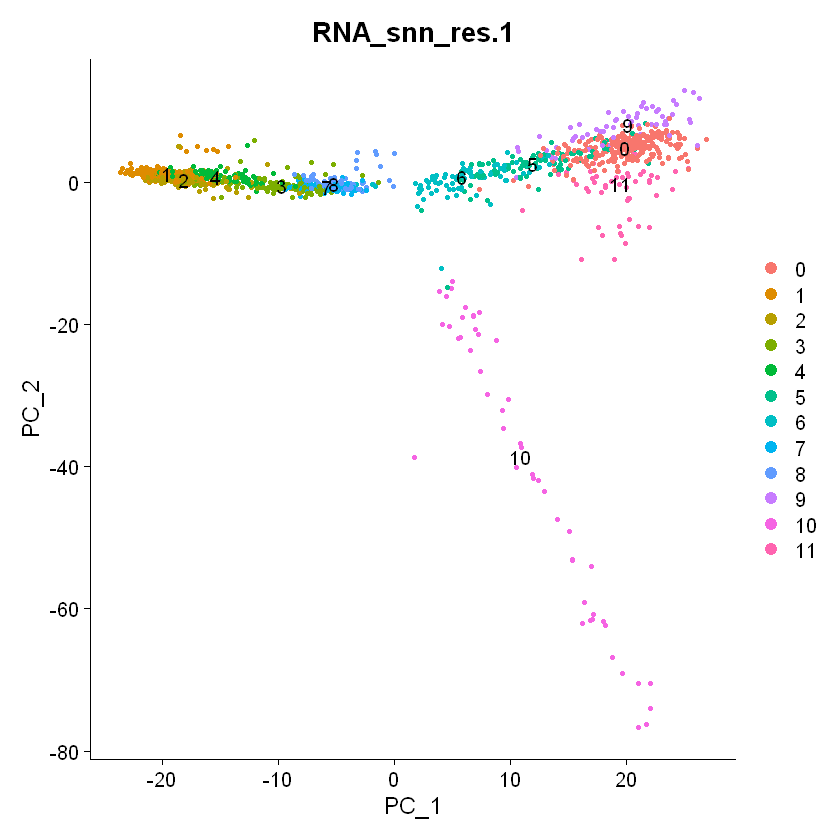

In [48]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.1", reduction = "pca", label = TRUE)

> ***Resolution = 1.2***

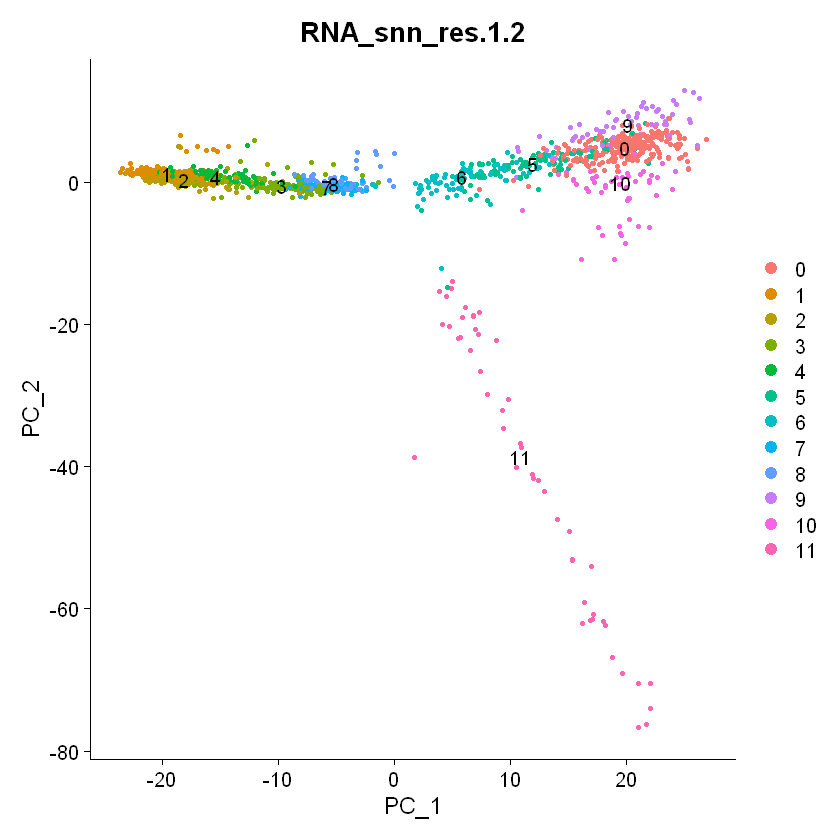

In [49]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.1.2", reduction = "pca", label = TRUE)

> ***Resolution = 1.4***

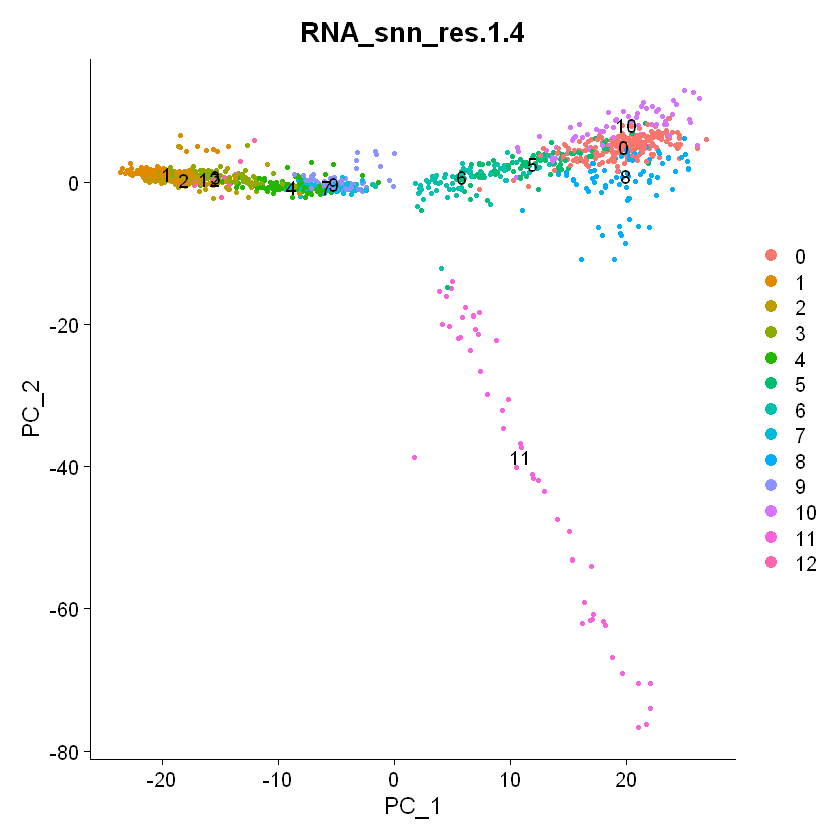

In [50]:
DimPlot(gbm.seurat.obj, group.by = "RNA_snn_res.1.4", reduction = "pca", label = TRUE)

> ***Since linear dimension reduced components are not that effective in terms of visualisation and explaining the underlying local structures in the data when compared to non-linear dimension techniques such as UMAP/t-SNE. Hence to decide on the accurate resolution which significantly sets the granularity and defines the clusters/communities would be confidently inferred by performing non-linear dimensionality reduction and visualisation of cell clusters using UMAP*** 

## <span style="color:blue; font-weight:bold;">10. Non-Linear Dimensionality Reduction - UMAP</span>

> **Non-linear dimensionality reduction techniques such as UMAP is very effective in preserving the local distances (local structures) in the dataset ensuring that cells with very similar gene expression profiles co-localize. Hence, to finalise the resoultion that defines the cell clusters, UMAP is implemented as below;**

In [ ]:
#UMAP embedding using RunUMAP() function
gbm.seurat.obj <- RunUMAP(gbm.seurat.obj, reduction = "pca", dims = 1:35)

> **UMAP embedding visualisation of cell clusters grouped by respective resoultion values**

> **Resolution = 0.1**

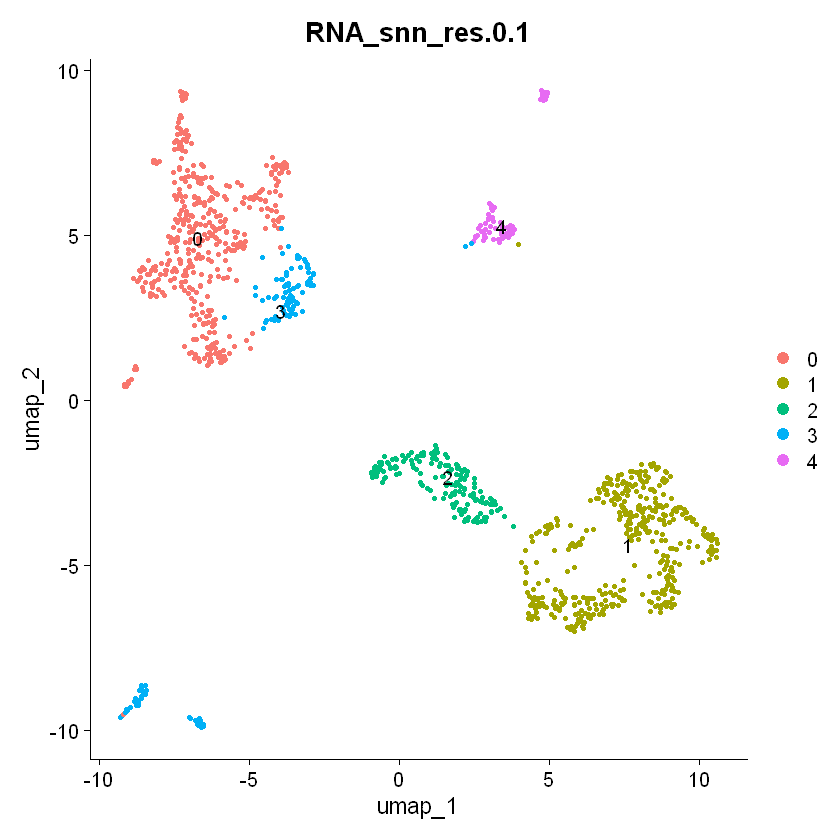

In [52]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.0.1",  label = TRUE)

> **Resolution = 0.2**

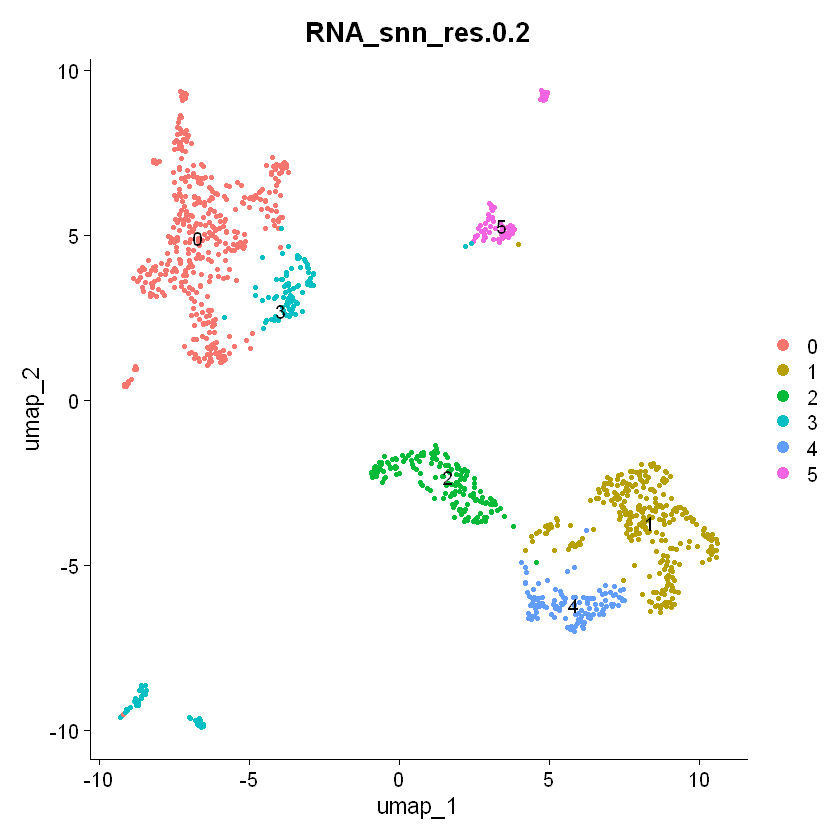

In [53]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.0.2",  label = TRUE)

> **Resolution = 0.3**

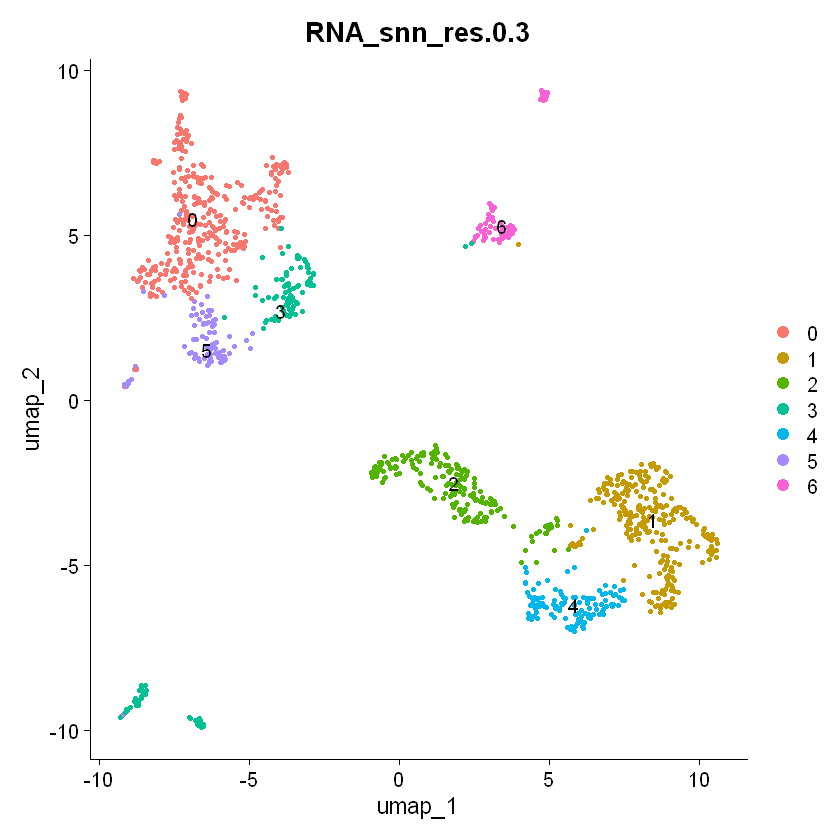

In [54]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.0.3",  label = TRUE)

> **Resolution = 0.4**

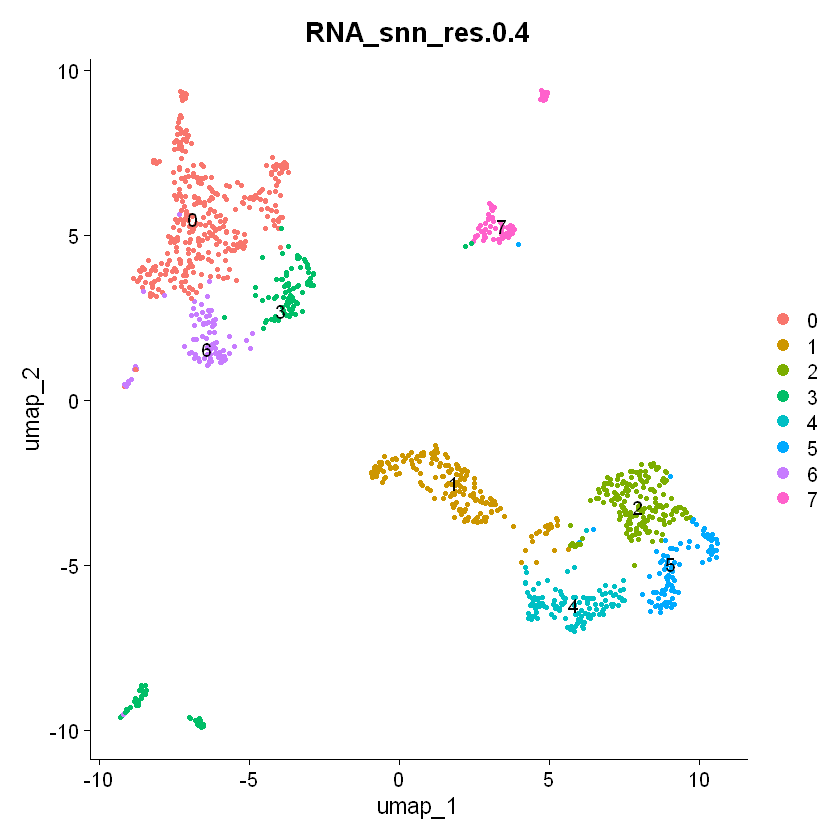

In [55]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.0.4",  label = TRUE)

> **Resolution = 0.5**

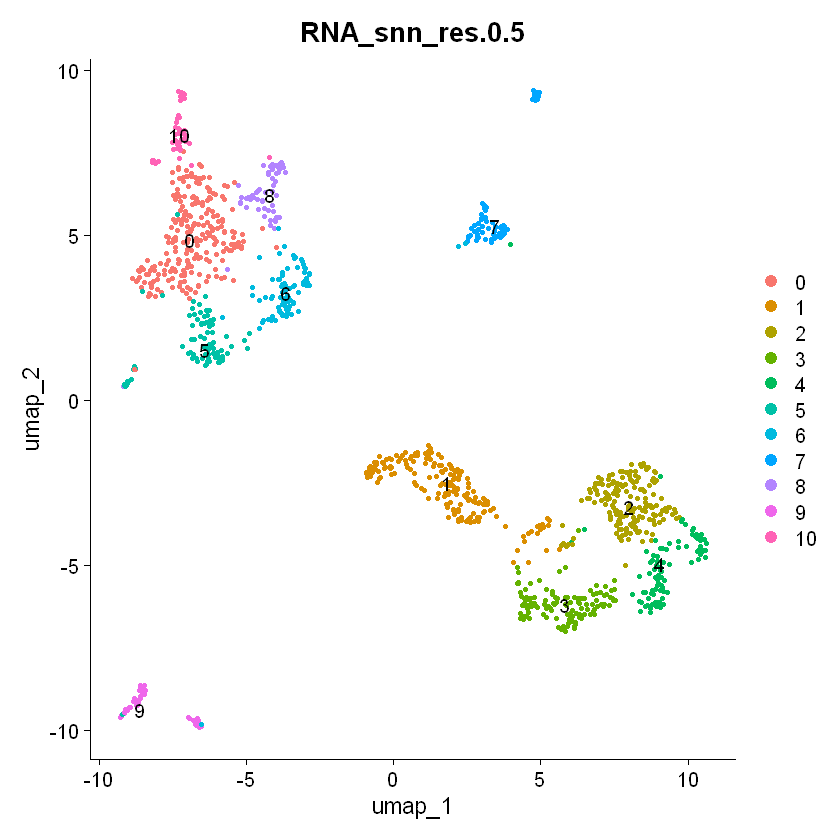

In [56]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.0.5",  label = TRUE)

> **Resolution = 0.7**

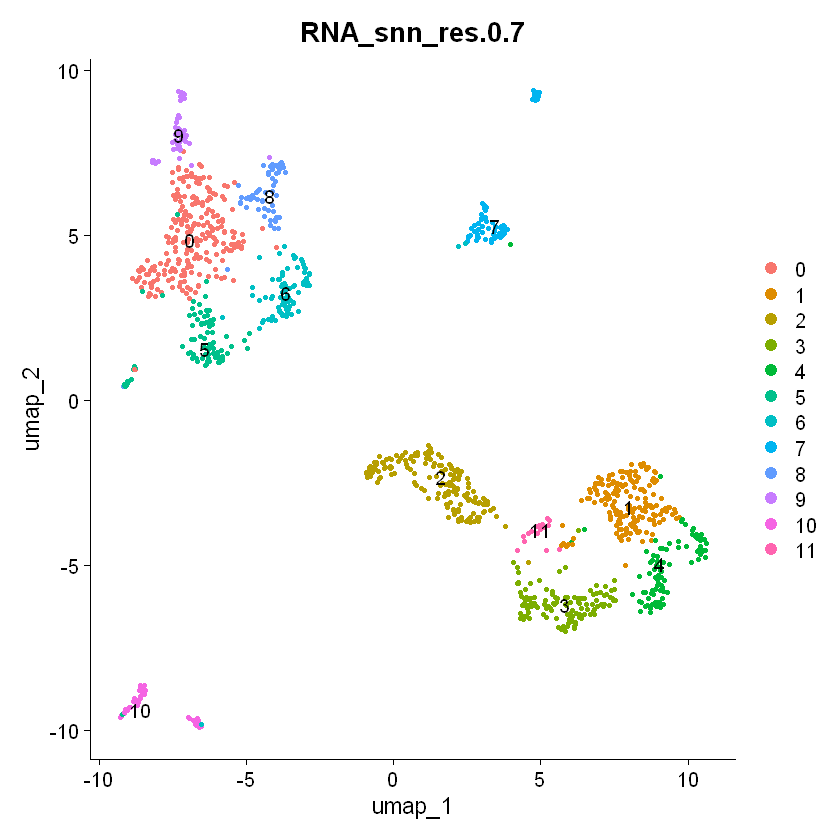

In [57]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.0.7",  label = TRUE)

> **Resolution = 1**

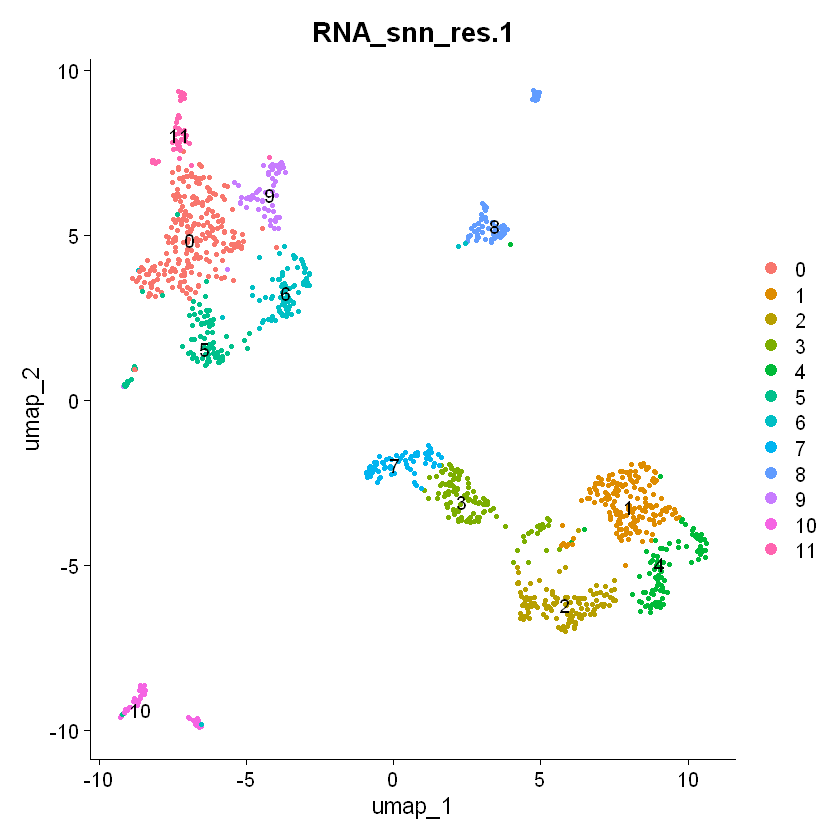

In [58]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.1",  label = TRUE)

> **Resolution = 1.2**

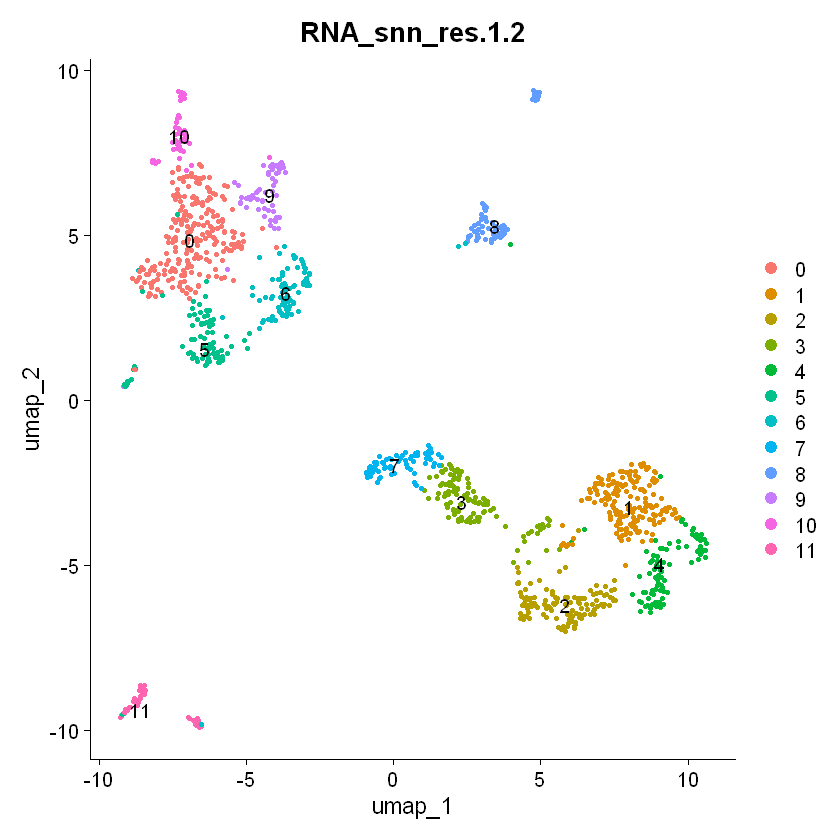

In [59]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.1.2",  label = TRUE)

> **Resolution = 1.4**

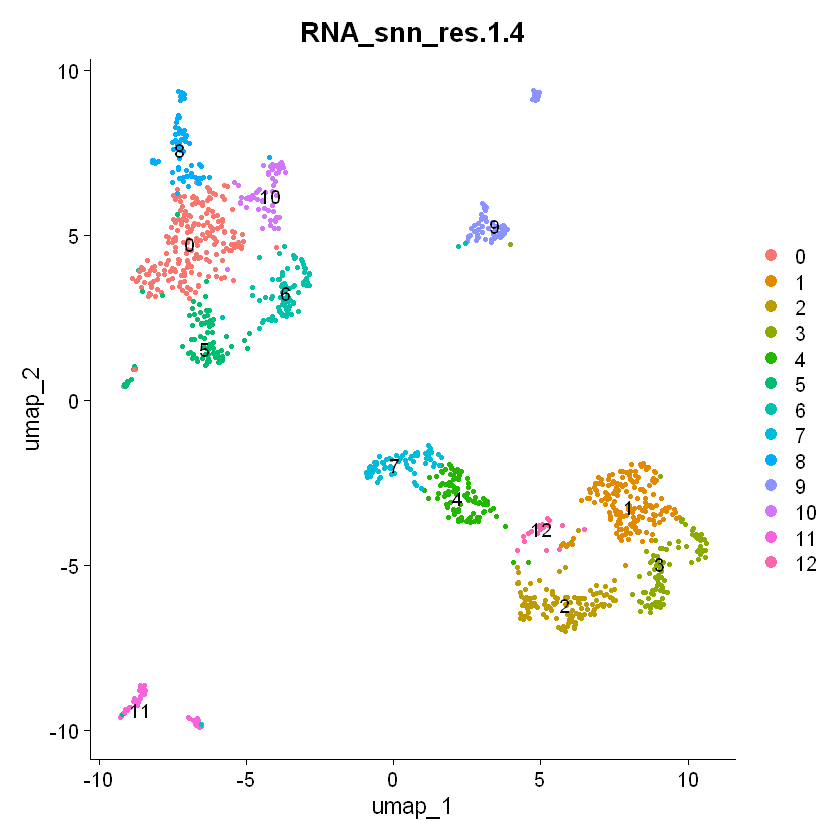

In [60]:
DimPlot(gbm.seurat.obj, reduction = "umap", group.by = "RNA_snn_res.1.4",  label = TRUE)

### <span style="color:OrangeRed; font-weight:bold;">10.1 Setting the IDENTITY of the clusters</span>

> Proceeding further, it is required to set the identity of the cells to a particular cluster as calibrated at resoultion = 0.2. 

>> Idents() function available in the Seurat library is exploited here

In [61]:
#Setting the cells identity to clusters from RNA_snn_res.0.2
Idents(gbm.seurat.obj) <- "RNA_snn_res.0.2"

In [62]:
#Check for the identity of the cells
head(Idents(gbm.seurat.obj))

AAACCCACATGTGTCA-1 AAACGAAAGAGAACCC-1 AAACGCTAGATTAGAC-1 AAACGCTGTACGCTAT-1 
                 1                  1                  5                  4 
AAAGAACAGTACAGCG-1 AAAGGATAGATTGTGA-1 
                 1                  1 
Levels: 0 1 2 3 4 5

### <span style="color:OrangeRed; font-weight:bold;">10.2 Interpretation and Inference - UMAP</span>

> **After close observation of the UMAP embedding plots and also with multiple back and forth iterations with identifying the cluster biomarkers, more specifically at the types of cells clustered together, it is decided to proceed with the clusters grouped at resoultion = 0.2.** 

> **Also it is very well known that glioblastoma multiforme (GBM) is very aggressive and hence a highly heterogenous tumor at the cellular level. But considering the sample size of 1221 cells post-QC, which is comparatively a lesser number. On the other side, it is also known that considering a high resoultion parameter would cluster the similar cell types into different clusters. Hence finding the right balance of all the conditions is very crucial. This needs to be supported by the inference obtained from visualisation. With thorough observation and cross-checking, for now proceeding with the clusters grouped at resoultion = 0.2.**

> **6 cell clusters were defined at resoultion 0.2, indexed 0 to 5 (0,1,2,3,4,5)**

> ***References: https://rdcu.be/dGZFW |||| https://doi.org/10.3390%2Fcancers13040761 |||| https://github.com/quadbio/scRNAseq_analysis_vignette/blob/master/Tutorial.md#step-2-quality-control***

## <span style="color:blue; font-weight:bold;">11. Differentially Expressed Features - Cluster Biomarkers</span>

> **To classify the cell clusters obtained from clustering analysis, identifying the differentially expressed features termed here as a "cluster biomarker" aids in defining the cell cluster/cell type of a particular community.**

> **A general well known approach with suitable functions available in the Seurat library is implemented here. Accordingly with the visualisation, interpretation is subsequently done.**

### <span style="color:OrangeRed; font-weight:bold;">11.1 Worflow of biomarkers identification</span>

> **1. Finding all the markers for each cluster with comparison made against rest of the cells** \
> **2. Identifying top 50 markers with independent avg_log2FC cutoff for each cluster** \
> **3. Visualisation of selected top 50 markers on Heatmap, compared across all the clusters** \
> **4. Violin plot depiction of uniquely expressed features** \
> **5. Visualisation of selected features on a dimensional reduction plot - UMAP** \
> **6. Dot Plot representation of the same features to check for expression levels in clusters** \
> **7. Cluster biomarker cross validation using CellMarker 2.0: http://bio-bigdata.hrbmu.edu.cn/CellMarker/index.html**

**Note: The entire process of cluster biomarker identification and cluster type identification is achieved via multiple iterations. Here, only the suitable steps are displayed.**

#### **Finding all the markers for each cluster with comparison made against rest of the cells**

In [63]:
#Using FindAllMarkers() cluster biomarkers for an independent cluster is identified by comparing with the rest of the cells in other clusters
gbm.seurat.obj.markers <- FindAllMarkers(gbm.seurat.obj, only.pos = TRUE)

Calculating cluster 0



For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



#### <span style="color:coral; font-weight:bold;">CLUSTER - 0</span>

> **Top 50 markers for cluster 0 with avg_log2FC > 3**

In [64]:
clus0_top50 <- gbm.seurat.obj.markers %>%
  filter(cluster %in% 0:0) %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 3) %>%
  slice_head(n = 50) %>%
  ungroup()



> **Heat map depiction for top 50 markers of cluster 0 compared across all the clusters**

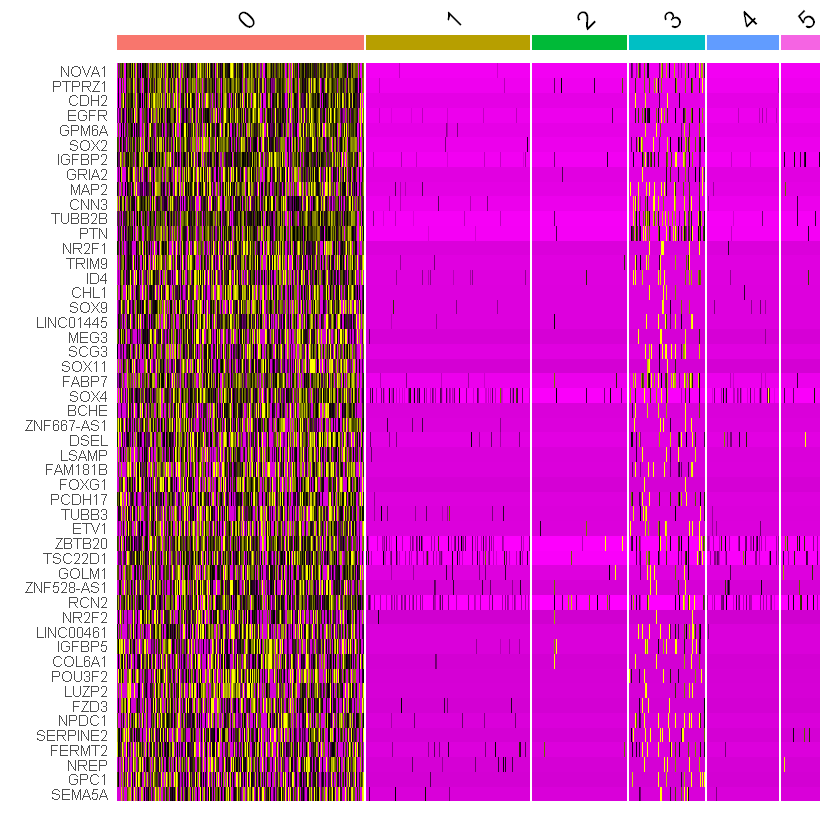

In [65]:
DoHeatmap(gbm.seurat.obj, features = clus0_top50$gene) + NoLegend()

> **Violin plot depiction to identify unique markers in cluster 0**

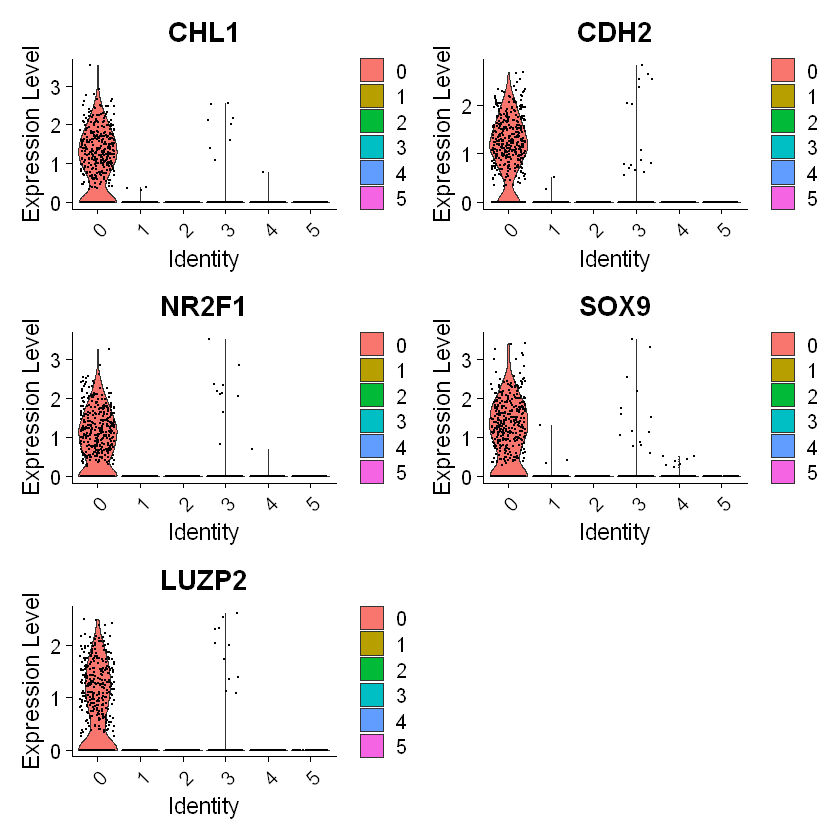

In [66]:
clus0_m1 <- VlnPlot(gbm.seurat.obj, features = "CHL1")
clus0_m2 <- VlnPlot(gbm.seurat.obj, features = "CDH2")
clus0_m3 <- VlnPlot(gbm.seurat.obj, features = "NR2F1")
clus0_m4 <- VlnPlot(gbm.seurat.obj, features = "SOX9")
clus0_m5 <- VlnPlot(gbm.seurat.obj, features = "LUZP2")

clus0_m1 + clus0_m2 + clus0_m3 + clus0_m4 + clus0_m5 + plot_layout(ncol = 2)

> **Visualize 'features' on a dimensional reduction plot - UMAP**

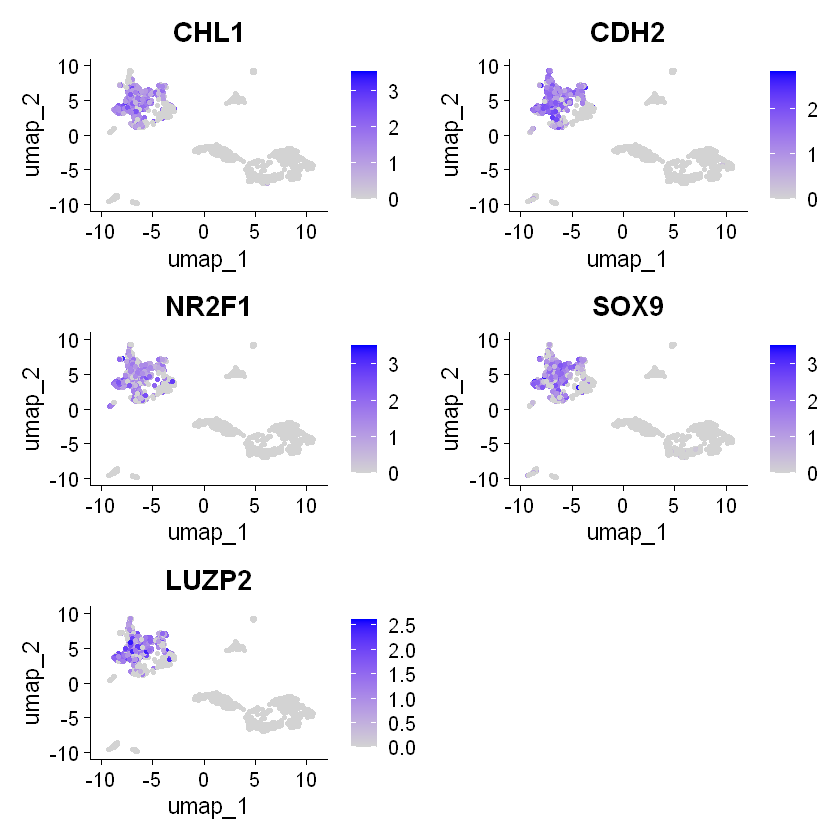

In [67]:
FeaturePlot(gbm.seurat.obj, features= c("CHL1", "CDH2", "NR2F1", "SOX9", "LUZP2"))

> **Dot plot visualisation to identify unique markers in cluster 0**

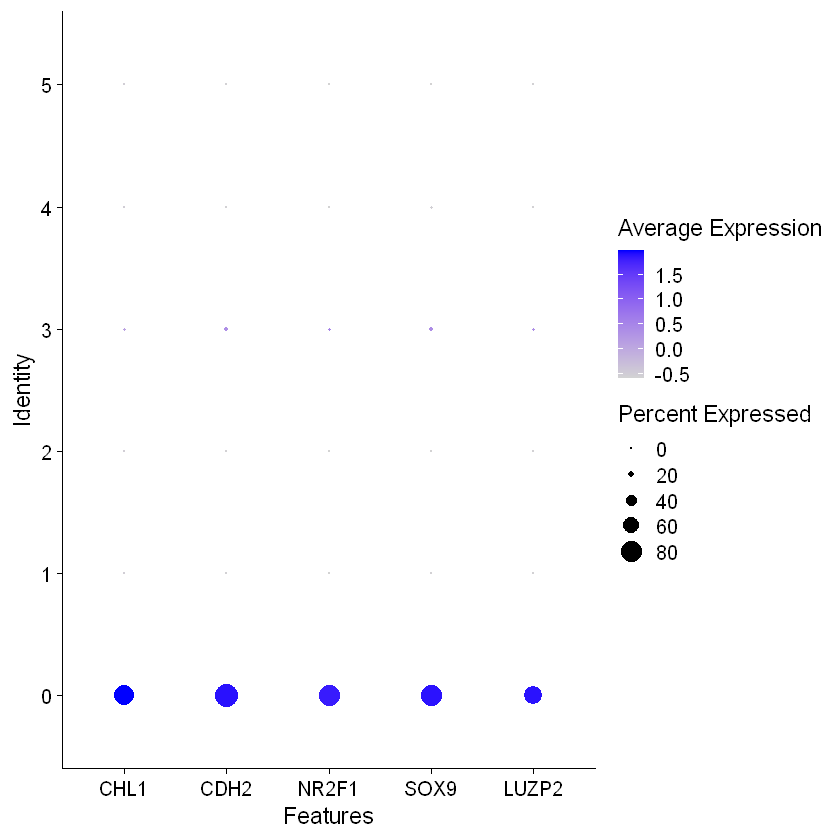

In [68]:
DotPlot(gbm.seurat.obj, features= c("CHL1", "CDH2", "NR2F1", "SOX9", "LUZP2"))

> ***Based on the above observation with multiple biomarkers being uniquely expressed in the cluster 0, it is evident and validated that the cluster 0 is composed of "Astrocytes"***

#### <span style="color:olive; font-weight:bold;">CLUSTER - 1</span>

> **Top 50 markers for cluster 1 with avg_log2FC > 3**

In [69]:
clus1_top50 <- gbm.seurat.obj.markers %>%
  filter(cluster %in% 1:1) %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 3) %>%
  slice_head(n = 50) %>%
  ungroup()



> **Heat map depiction for top 50 markers of cluster 1 compared across all the clusters**

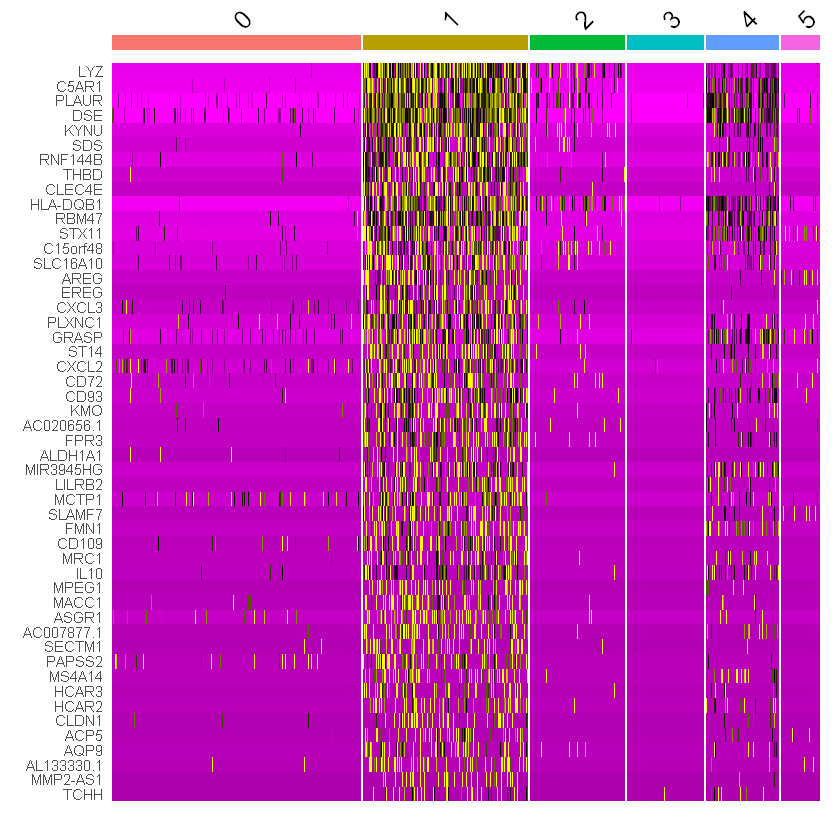

In [70]:
DoHeatmap(gbm.seurat.obj, features = clus1_top50$gene) + NoLegend()

> **Violin plot depiction to identify unique markers in cluster 1**

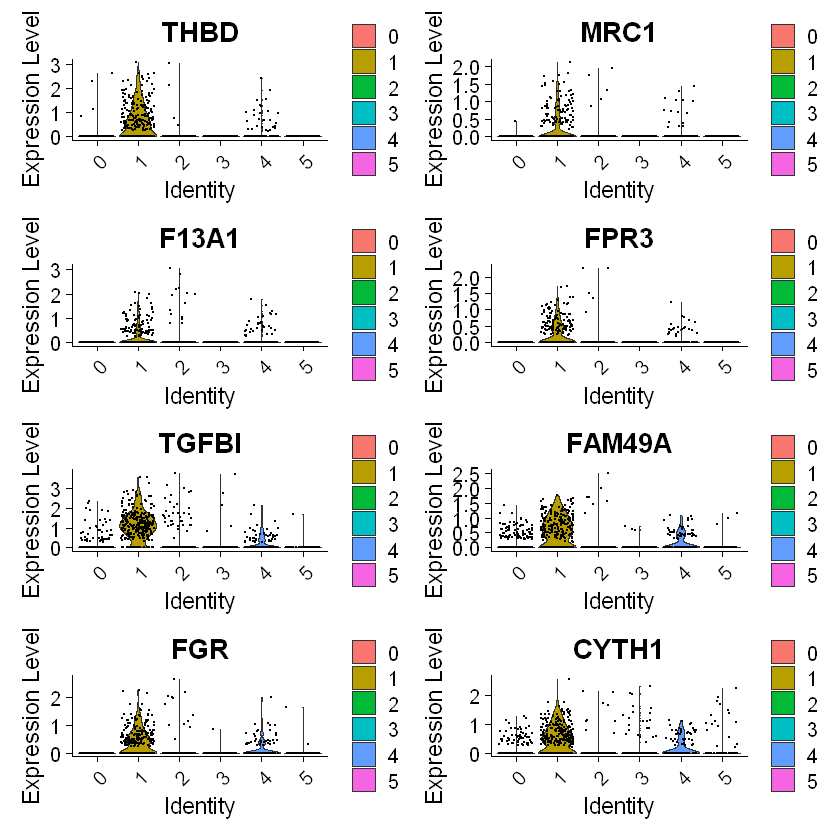

In [71]:
clus1_m1 <- VlnPlot(gbm.seurat.obj, features = "THBD")
clus1_m2 <- VlnPlot(gbm.seurat.obj, features = "MRC1")
clus1_m3 <- VlnPlot(gbm.seurat.obj, features = "F13A1")
clus1_m4 <- VlnPlot(gbm.seurat.obj, features = "FPR3")
clus1_m5 <- VlnPlot(gbm.seurat.obj, features = "TGFBI")
clus1_m6 <- VlnPlot(gbm.seurat.obj, features = "FAM49A")
clus1_m7 <- VlnPlot(gbm.seurat.obj, features = "FGR")
clus1_m8 <- VlnPlot(gbm.seurat.obj, features = "CYTH1")

clus1_m1 + clus1_m2 + clus1_m3 + clus1_m4 + clus1_m5 + clus1_m6 + clus1_m7 + clus1_m8 + plot_layout(ncol = 2)

> **Visualize 'features' on a dimensional reduction plot - UMAP**

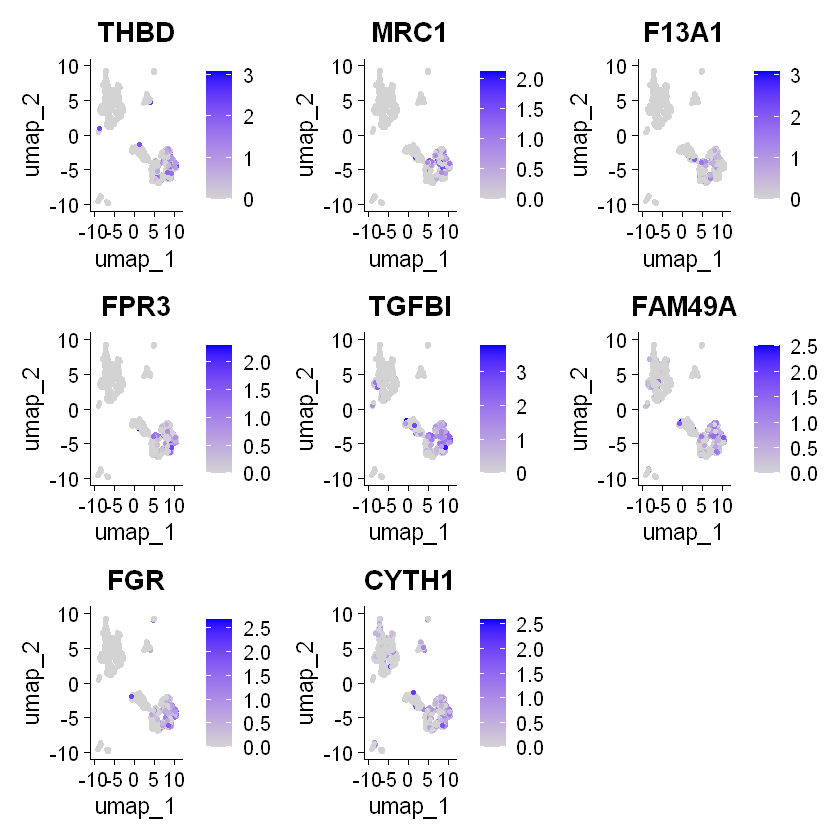

In [72]:
FeaturePlot(gbm.seurat.obj, features= c("THBD", "MRC1", "F13A1", "FPR3", "TGFBI", "FAM49A", "FGR", "CYTH1"))

> **Dot plot visualisation to identify unique markers in cluster 1**

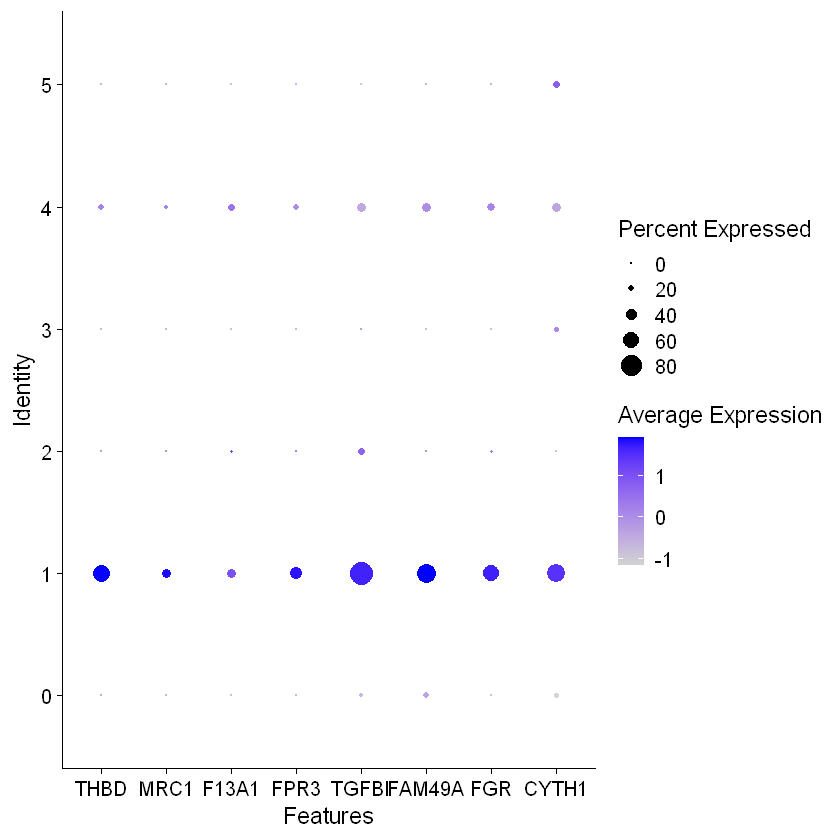

In [73]:
DotPlot(gbm.seurat.obj, features= c("THBD", "MRC1", "F13A1", "FPR3", "TGFBI", "FAM49A", "FGR", "CYTH1"))

> ***Even though a few of the selected markers for cluster 1 are expressed in other clusters, mainly in cluster 4, the expression level in cluster 1 is higher and hence it is validated with multiple markers. With these markers identified it was validated that, cluster composition is primarily of "Macrophages"***

#### <span style="color:green; font-weight:bold;">CLUSTER - 2</span>

> **Top 50 markers for cluster 2 with avg_log2FC > 2**

In [74]:
clus2_top50 <- gbm.seurat.obj.markers %>%
  filter(cluster %in% 2:2) %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 2) %>%
  slice_head(n = 50) %>%
  ungroup()


> **Heat map depiction for top 50 markers of cluster 2 compared across all the clusters**

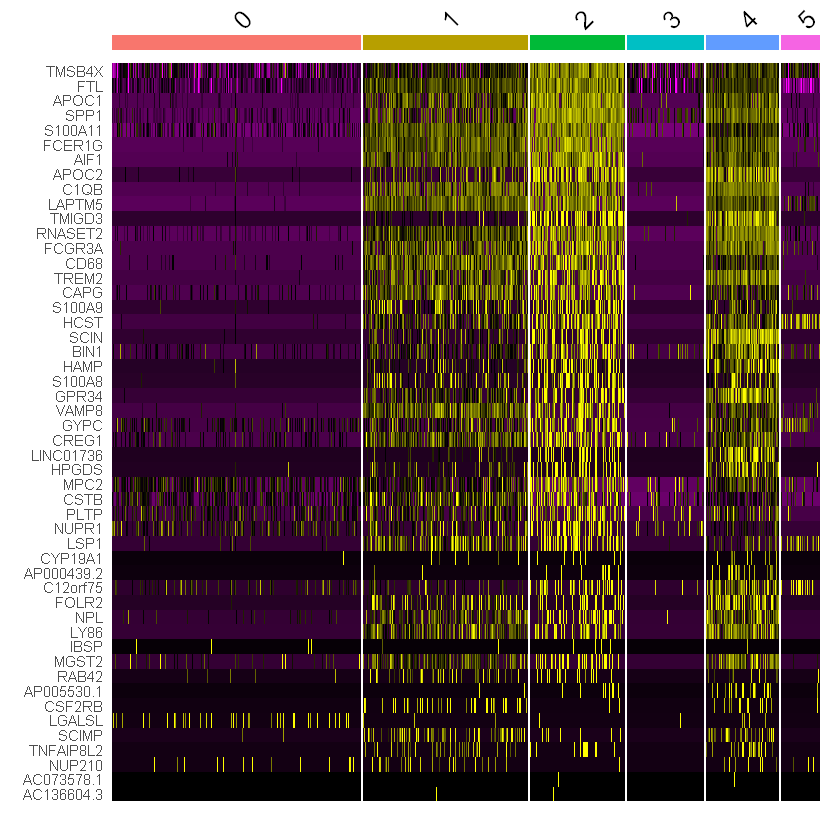

In [75]:
DoHeatmap(gbm.seurat.obj, features = clus2_top50$gene) + NoLegend()

> **Violin plot depiction to identify unique markers in cluster 2**

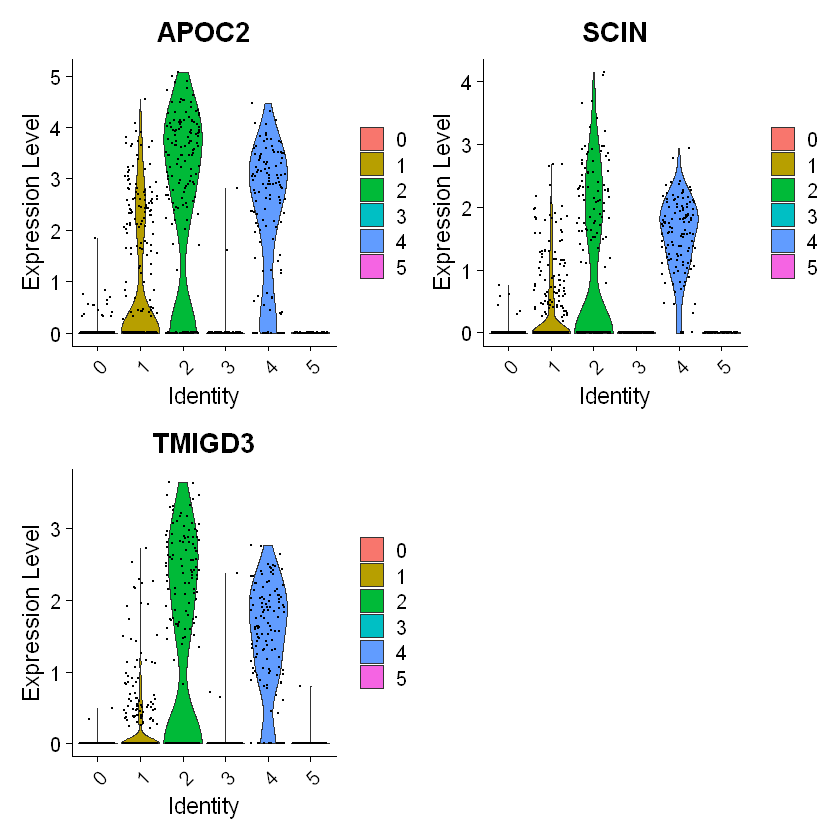

In [76]:
clus2_m1 <- VlnPlot(gbm.seurat.obj, features = "APOC2")
clus2_m2 <- VlnPlot(gbm.seurat.obj, features = "SCIN")
clus2_m3 <- VlnPlot(gbm.seurat.obj, features = "TMIGD3")

clus2_m1 + clus2_m2 + clus2_m3 + plot_layout(ncol = 2)

> **Visualize 'features' on a dimensional reduction plot - UMAP**

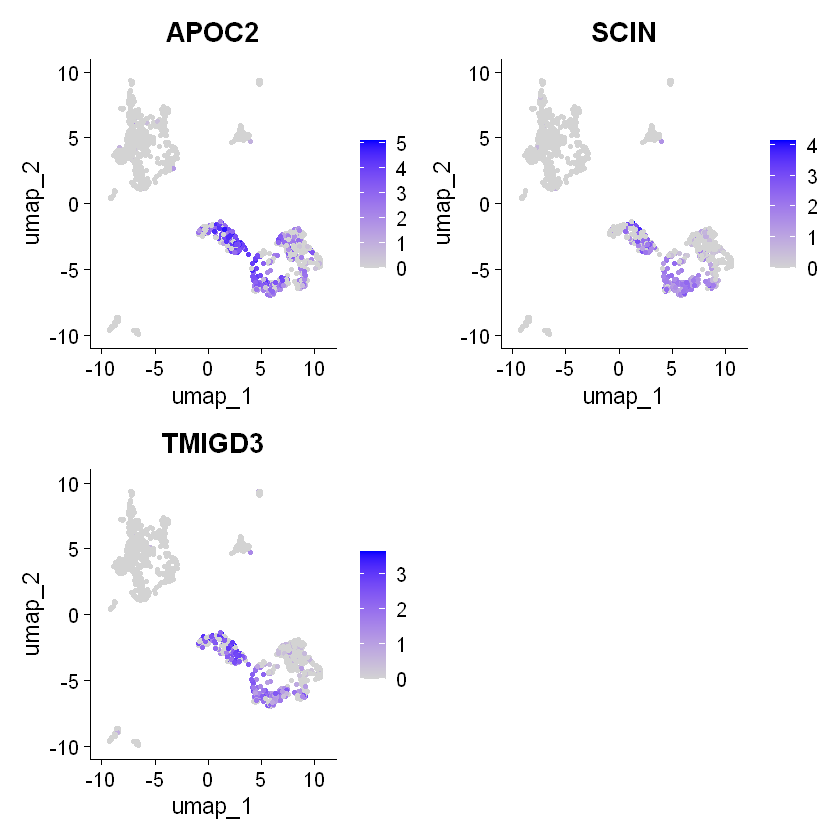

In [77]:
FeaturePlot(gbm.seurat.obj, features= c("APOC2", "SCIN", "TMIGD3"))

> **Dot plot visualisation to identify unique markers in cluster 2**

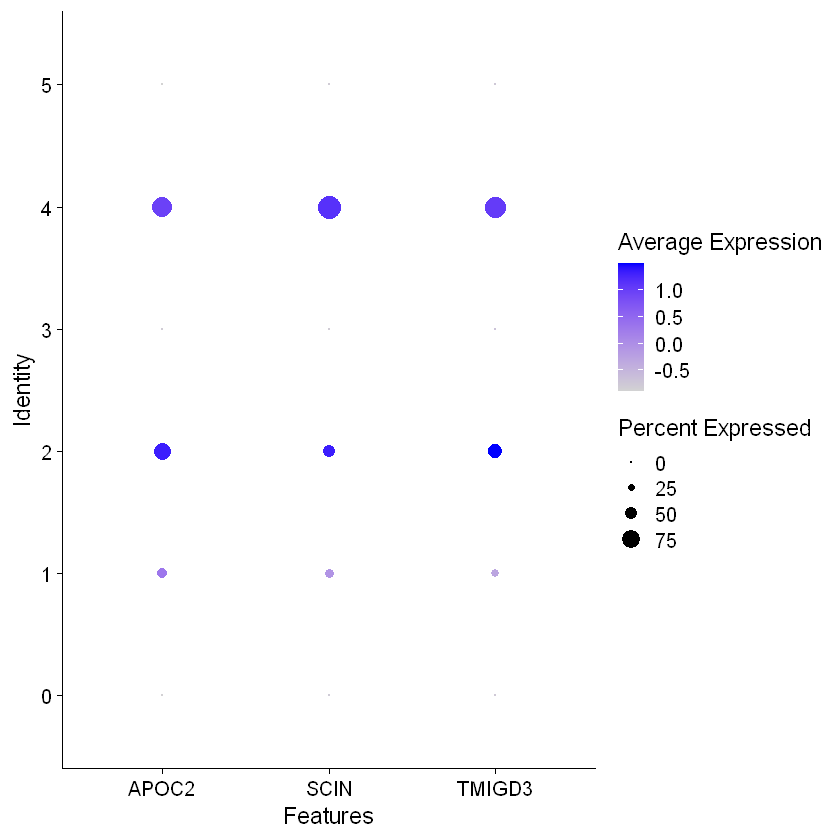

In [78]:
DotPlot(gbm.seurat.obj, features= c("APOC2", "SCIN", "TMIGD3"))

> ***Interpretation of cluster 2 is non-trivial as it could be observed with the visualisations. But closely observed, it could be seen that cluster 2 has slightly higher expression of the selected markers comapred to cluster 1 and 4. Also, it is a bit tougher job to clearly distinguish cluster 2 from cluster 1 and 4, this is because, it is well known that "Mg-TAM has similar expression levels of most of the features when compared to macrophages and microglial cells, beacuse of their function. (This was inferred with the cluster annotation of all). But the selected 3 markers are studied to be the cell markers for "Microglia-derived Tumor-associated macrophages (Mg-TAMs)***

#### <span style="color:teal; font-weight:bold;">CLUSTER - 3</span>

> **Top 50 markers for cluster 3 with avg_log2FC > 2**

In [79]:
clus3_top50 <- gbm.seurat.obj.markers %>%
  filter(cluster %in% 3:3) %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 2) %>%
  slice_head(n = 50) %>%
  ungroup()


> **Heat map depiction for top 50 markers of cluster 3 compared across all the clusters**

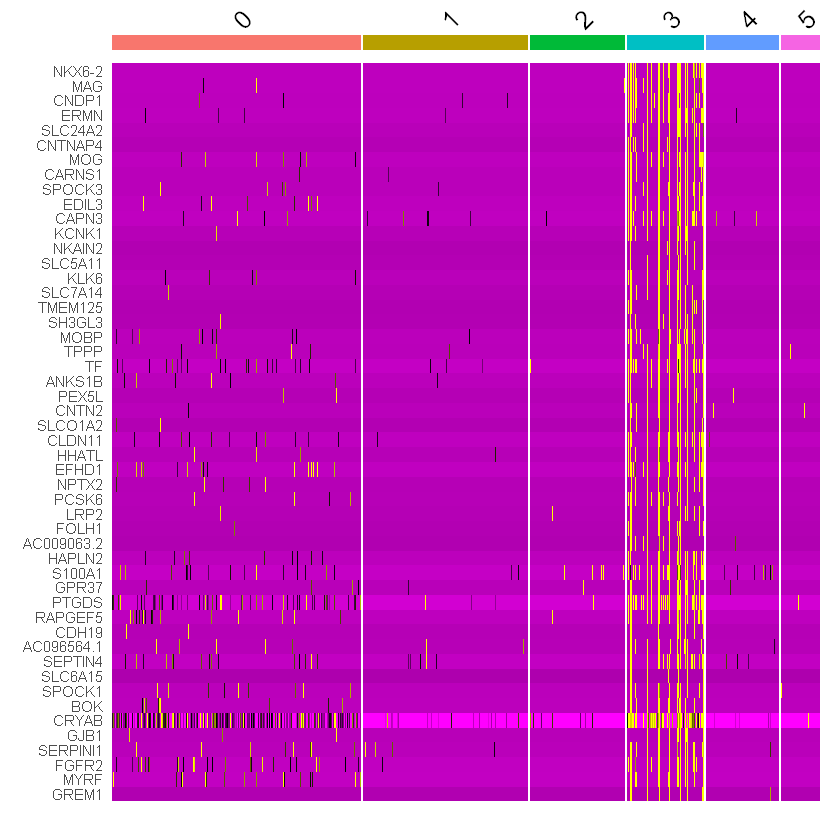

In [80]:
DoHeatmap(gbm.seurat.obj, features = clus3_top50$gene) + NoLegend()

> **Violin plot depiction to identify unique markers in cluster 3**

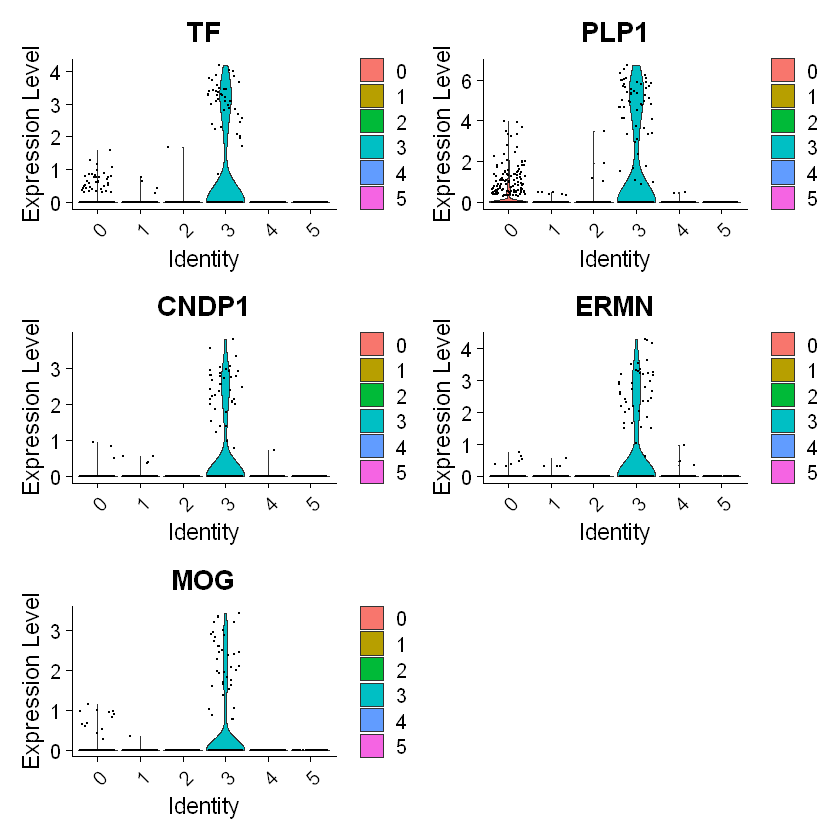

In [81]:
clus3_m1 <- VlnPlot(gbm.seurat.obj, features = "TF")
clus3_m2 <- VlnPlot(gbm.seurat.obj, features = "PLP1")
clus3_m3 <- VlnPlot(gbm.seurat.obj, features = "CNDP1")
clus3_m4 <- VlnPlot(gbm.seurat.obj, features = "ERMN")
clus3_m5 <- VlnPlot(gbm.seurat.obj, features = "MOG")

clus3_m1 + clus3_m2 + clus3_m3 + clus3_m4 + clus3_m5 + plot_layout(ncol = 2)

> **Visualize 'features' on a dimensional reduction plot - UMAP**

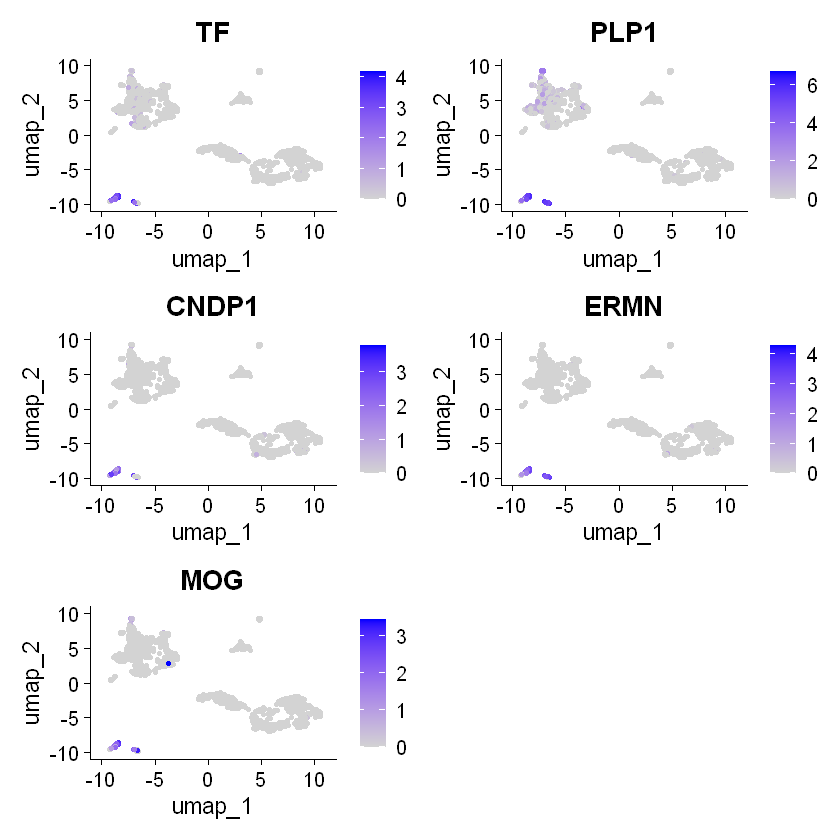

In [82]:
FeaturePlot(gbm.seurat.obj, features= c("TF", "PLP1", "CNDP1", "ERMN", "MOG"))

> **Dot plot visualisation to identify unique markers in cluster 3**

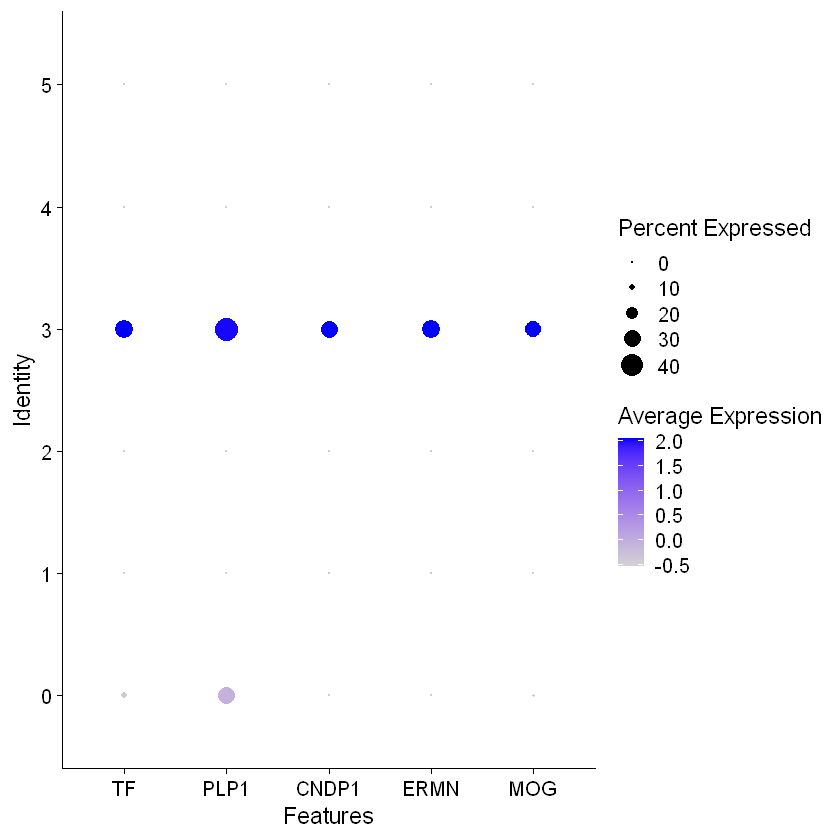

In [83]:
DotPlot(gbm.seurat.obj, features= c("TF", "PLP1", "CNDP1", "ERMN", "MOG"))

> ***Based on the above observation with multiple biomarkers being uniquely expressed in the cluster 3, it is evident and validated that the cluster 3 is composed of "Oligodendrocytes"***

#### <span style="color:skyblue; font-weight:bold;">CLUSTER - 4</span>

> **Top 50 markers for cluster 4 with avg_log2FC > 3**

In [84]:
clus4_top50 <- gbm.seurat.obj.markers %>%
  filter(cluster %in% 4:4) %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 3) %>%
  slice_head(n = 50) %>%
  ungroup()


> **Heat map depiction for top 50 markers of cluster 4 compared across all the clusters**

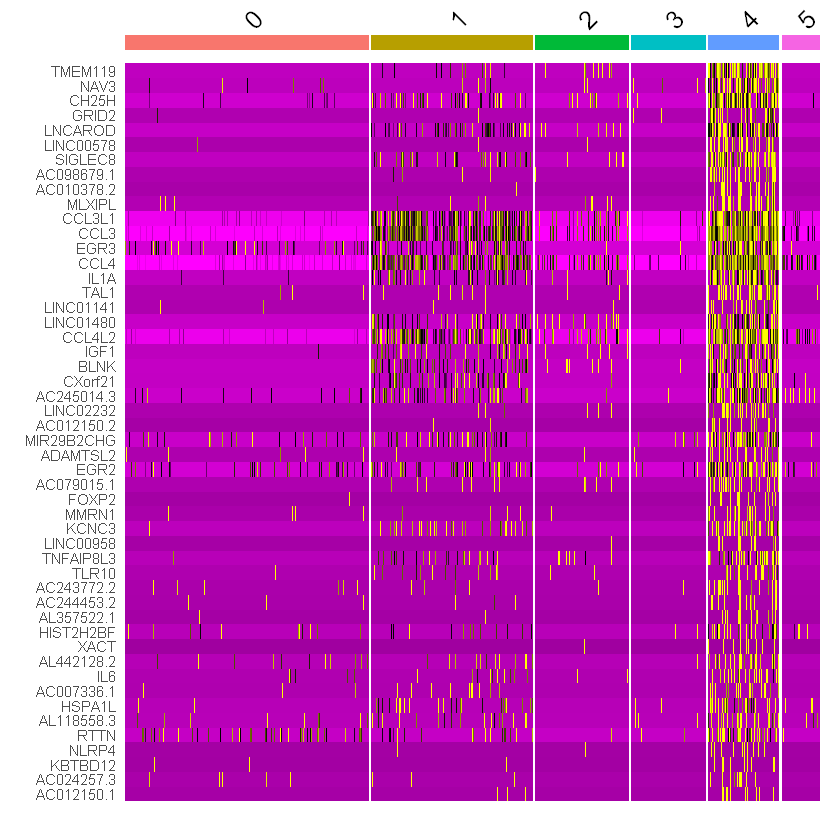

In [85]:
DoHeatmap(gbm.seurat.obj, features = clus4_top50$gene) + NoLegend()

> **Violin plot depiction to identify unique markers in cluster 4**

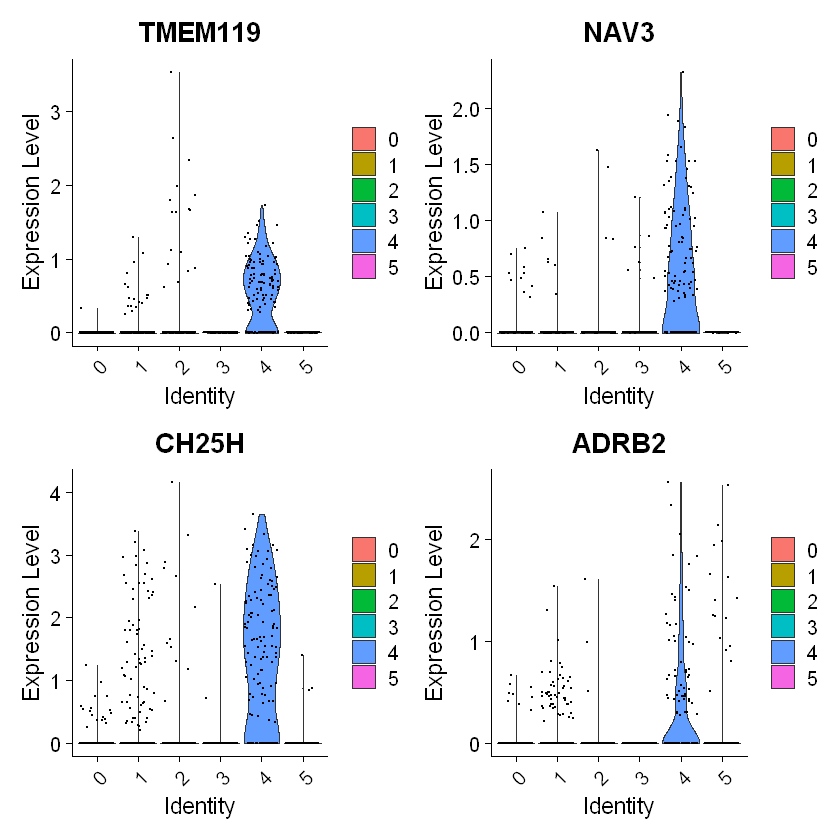

In [86]:
clus4_m1 <- VlnPlot(gbm.seurat.obj, features = "TMEM119")
clus4_m2 <- VlnPlot(gbm.seurat.obj, features = "NAV3")
clus4_m3 <- VlnPlot(gbm.seurat.obj, features = "CH25H")
clus4_m4 <- VlnPlot(gbm.seurat.obj, features = "ADRB2")

clus4_m1 + clus4_m2 + clus4_m3 + clus4_m4 + plot_layout(ncol = 2)

> **Visualize 'features' on a dimensional reduction plot - UMAP**

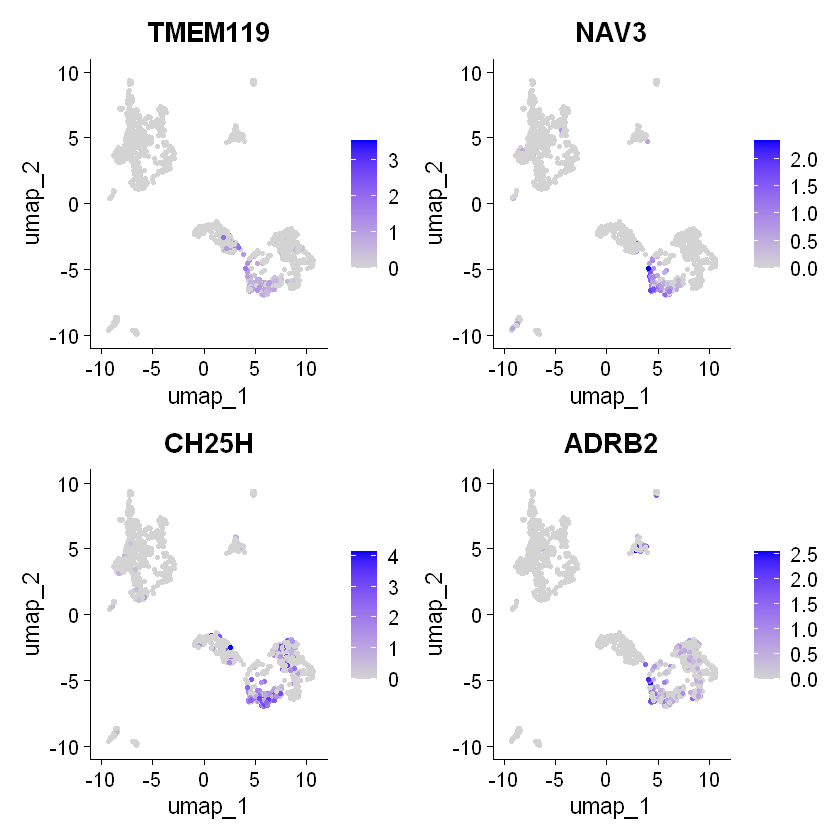

In [87]:
FeaturePlot(gbm.seurat.obj, features = c("TMEM119", "NAV3", "CH25H", "ADRB2"), ncol = 2)

> **Dot plot visualisation to identify unique markers in cluster 4**

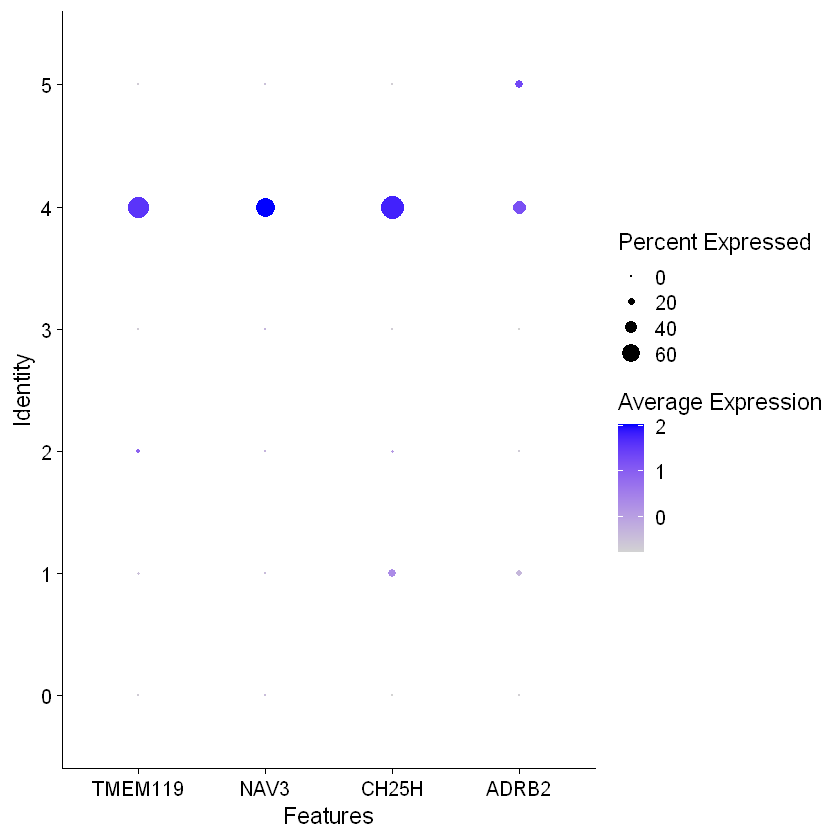

In [88]:
DotPlot(gbm.seurat.obj, features = c("TMEM119", "NAV3", "CH25H", "ADRB2"))

> ***Based on the above observation with multiple biomarkers being uniquely expressed in the cluster 4, it is evident and validated that the cluster 4 is composed of "Microglial Cells"***

#### <span style="color:magenta; font-weight:bold;">CLUSTER - 5</span>

> **Top 50 markers for cluster 5 with avg_log2FC > 3**

In [89]:
clus5_top50 <- gbm.seurat.obj.markers %>%
  filter(cluster %in% 5:5) %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 3) %>%
  slice_head(n = 50) %>%
  ungroup()


> **Heat map depiction for top 50 markers of cluster 5 compared across all the clusters**

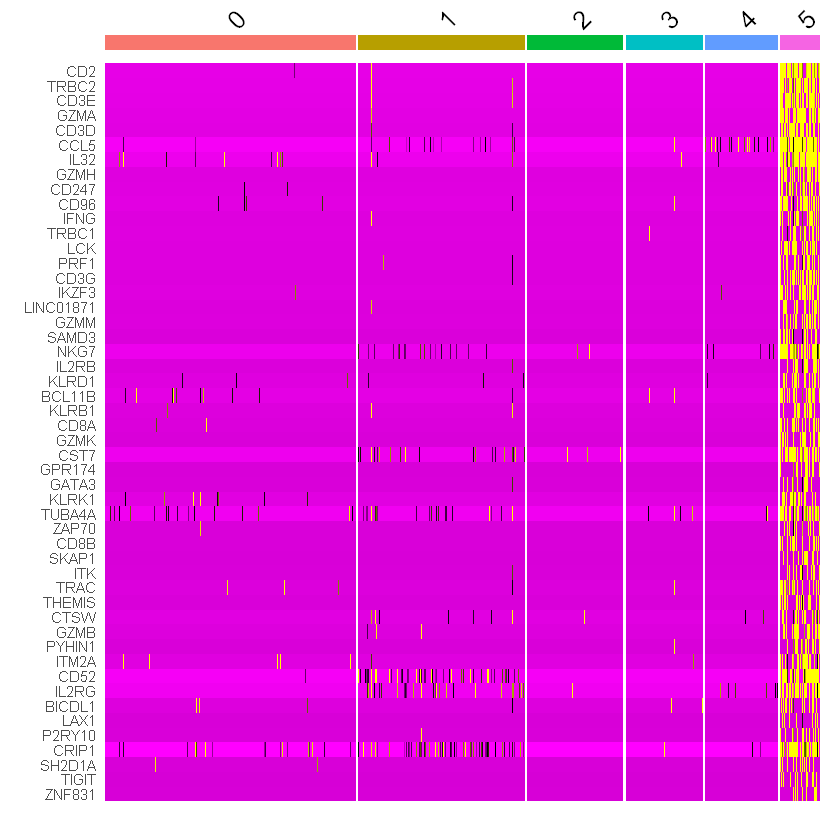

In [90]:
DoHeatmap(gbm.seurat.obj, features = clus5_top50$gene) + NoLegend()

> **Violin plot depiction to identify unique markers in cluster 5**

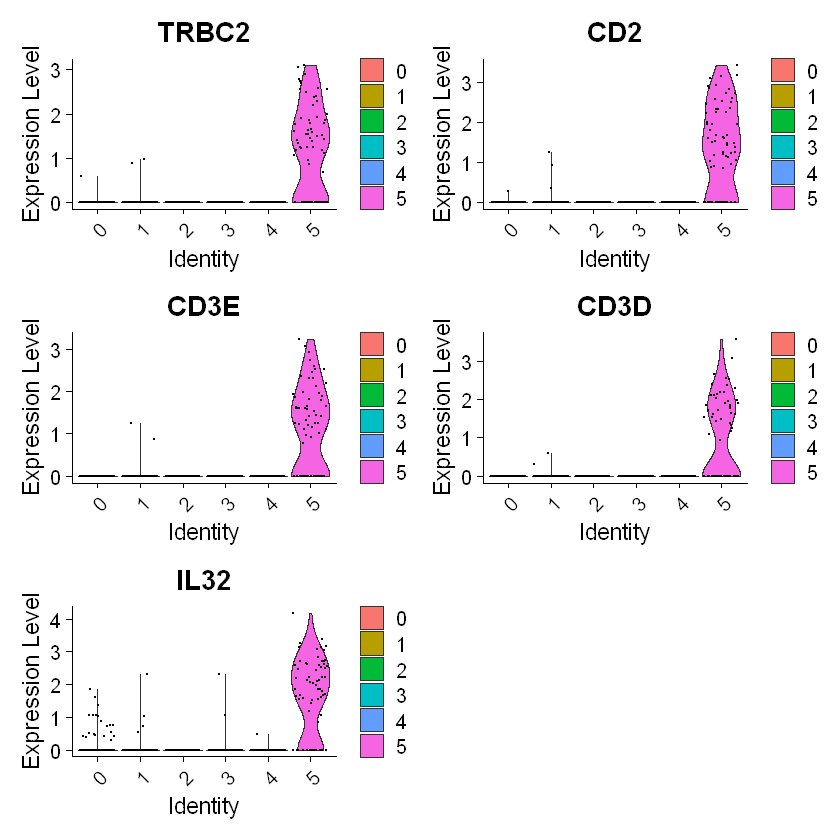

In [91]:
clus5_m1 <- VlnPlot(gbm.seurat.obj, features = "TRBC2")
clus5_m2 <- VlnPlot(gbm.seurat.obj, features = "CD2")
clus5_m3 <- VlnPlot(gbm.seurat.obj, features = "CD3E")
clus5_m4 <- VlnPlot(gbm.seurat.obj, features = "CD3D")
clus5_m5 <- VlnPlot(gbm.seurat.obj, features = "IL32")

clus5_m1 + clus5_m2 + clus5_m3 + clus5_m4 + clus5_m5 + plot_layout(ncol = 2)

> **Visualize 'features' on a dimensional reduction plot - UMAP**

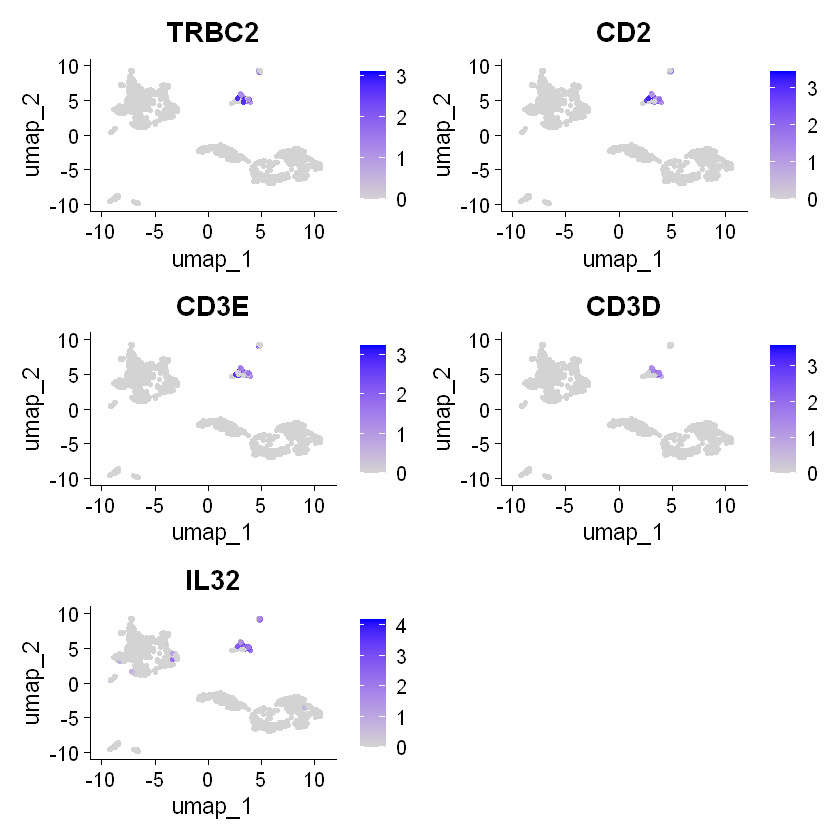

In [92]:
FeaturePlot(gbm.seurat.obj, features = c("TRBC2", "CD2", "CD3E", "CD3D", "IL32"), ncol = 2)

> **Dot plot visualisation to identify unique markers in cluster 5**

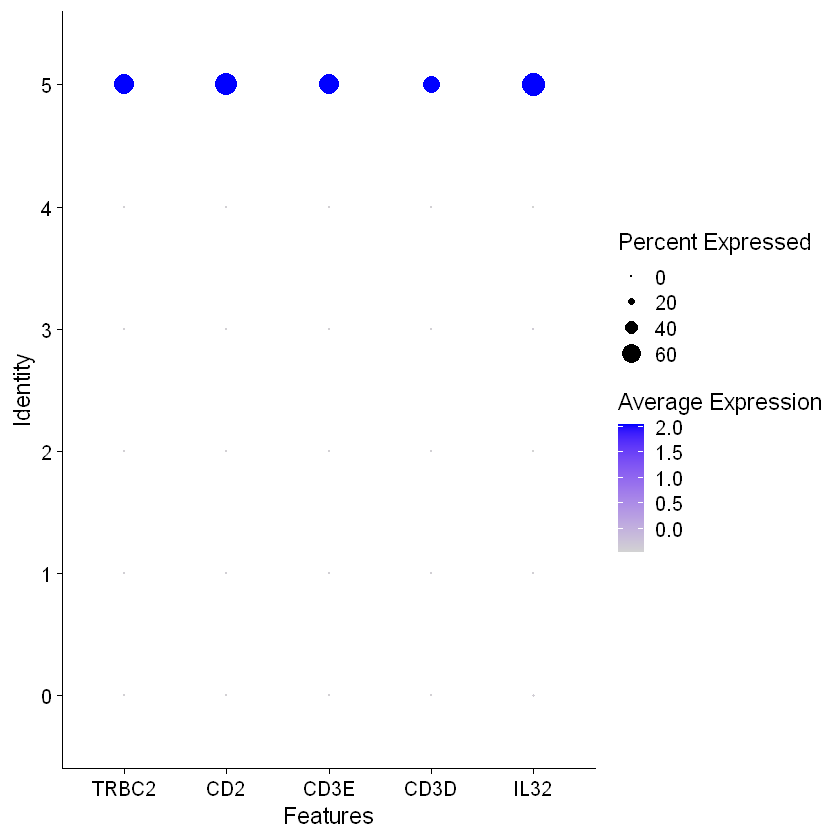

In [93]:
DotPlot(gbm.seurat.obj, features = c("TRBC2", "CD2", "CD3E", "CD3D", "IL32"))

> ***Based on the above observation with multiple biomarkers being uniquely expressed in the cluster 5, it is evident and validated that the cluster 5 is composed of "T-cells"***

## <span style="color:blue; font-weight:bold;">12. Cluster Annotation - Assigning Cell Type Identity to Clusters</span> 

> ***After thorough interpretation of the biomarkers for each clusters independently along with their uniquness in their expression levels and distribution across the clusters, the cell types were declared as below:***

| Cluster ID      | Markers                                           | Cell type                                    |
| :---------------- | :------------------------------------------------  | :-------------------------------------------- |
| 0                 | CHL1, CDH2, NR2F1, SOX9, LUZP2                     | ***Astrocytes***                                    |
| 1                 | THBD, MRC1, F13A1, FPR3, TGFBI, FAM49A, FGR, CYTH1 | ***Macrophages***                                   |
| 2                 | APOC2, SCIN, TMIGD3                                | ***Microglia-derived Tumor-Associated Macrophage (Mg-TAM)*** |
| 3                 | TF, PLP1, CNDP1, ERMN, MOG                         | ***Oligodendrocytes***                              |
| 4                 | TMEM119, NAV3, CH25H, ADRB2                        | ***Microglial cells***                              |
| 5                 | TRBC2, CD2, CD3E, CD3D, IL32                       | ***T-cell***                                        |

### <span style="color:OrangeRed; font-weight:bold;">12.1 Cluster Labelling</span> 

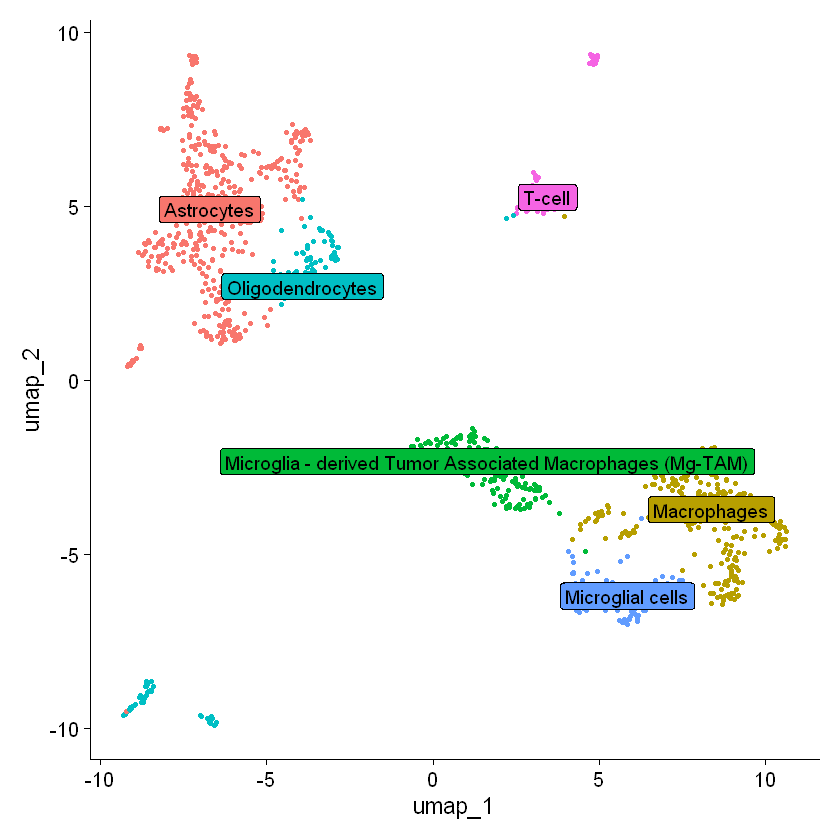

In [94]:
new.cluster.ids <- c("Astrocytes", "Macrophages", "Microglia - derived Tumor Associated Macrophages (Mg-TAM)", "Oligodendrocytes", "Microglial cells", "T-cell")
names(new.cluster.ids) <- levels(gbm.seurat.obj)
gbm.seurat.obj <- RenameIdents(gbm.seurat.obj, new.cluster.ids)
DimPlot(gbm.seurat.obj, reduction = "umap", label = TRUE, label.size = 4, label.box = TRUE, pt.size = 1, raster.dpi = c(10000, 10000)) + NoLegend()

In [95]:
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_India.utf8  LC_CTYPE=English_India.utf8   
[3] LC_MONETARY=English_India.utf8 LC_NUMERIC=C                  
[5] LC_TIME=English_India.utf8    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] purrr_1.0.2        ggrepel_0.9.5      ggplot2_3.5.1      patchwork_1.2.0   
[5] dplyr_1.1.4        hdf5r_1.3.10       Seurat_5.0.3       SeuratObject_5.0.1
[9] sp_2.1-3          

loaded via a namespace (and not attached):
  [1] Rtsne_0.17             colorspace_2.1-0       deldir_2.0-4          
  [4] ggridges_0.5.6         IRdisplay_1.1          RcppHNSW_0.6.0        
  [7] base64enc_0.1-3        spatstat.data_3.0-4    farver_2.1.1          
 [10] leiden_0.4.3.1         listenv_0.9.1          bit64_4.0.5           
 [13] RSpectra_0.16-1     